In [1]:
# @title Загружаем файл bank-additional-full.csv
from google.colab import files

uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [2]:
# @title Создаем папку data и перемещаем файл
!mkdir -p data
!mv bank-additional-full.csv data/


# Проверяем
!ls -la data/

total 5708
drwxr-xr-x 2 root root    4096 Sep 28 17:14 .
drwxr-xr-x 1 root root    4096 Sep 28 17:14 ..
-rw-r--r-- 1 root root 5834924 Sep 28 17:14 bank-additional-full.csv


In [3]:
# @title Создаем БД проекта и сырую таблицу raw_bank_marketing с данными из bank-additional-full.csv
# Важно: после пересоздания БД - до построения модели обязательно запустить предобработку
# database
import sqlite3
import pandas as pd
import os

def check_data_files():
    """Проверка наличия CSV файлов."""
    print("Проверяем наличие CSV файлов...")

    required_files = [
        'data/bank-additional-full.csv'
    ]

    all_files_exist = True
    for file in required_files:
        if os.path.exists(file):
            size = os.path.getsize(file)
            print(f"{file} ({size} байт)")
        else:
            print(f"{file} - ОТСУТСТВУЕТ!")
            all_files_exist = False

    return all_files_exist

def delete_existing_database():
    """Удаление существующей базы данных, если она есть"""
    print("Проверяем существующую базу данных...")
    if os.path.exists('bank_marketing.db'):
        os.remove('bank_marketing.db')
        print("Существующая база данных удалена")
    else:
        print("База данных не существует, создаем новую")

def print_table_sample(conn, table_name, limit=10):
    """Вывод sample данных из таблицы"""
    print(f"\nСодержимое таблицы {table_name} (первые {limit} записей):")
    print("-" * 60)
    try:
        query = f"SELECT * FROM {table_name} LIMIT {limit}"
        df = pd.read_sql_query(query, conn)
        if len(df) > 0:
            print(df.to_string(index=False))
            print(f"Всего записей в таблице: {pd.read_sql_query(f'SELECT COUNT(*) FROM {table_name}', conn).iloc[0,0]}")

            # Дополнительная информация о таблице
            print(f"\nСтруктура таблицы {table_name}:")
            print(f"Кол-во колонок: {len(df.columns)}")
            print("Колонки:")
            for i, col in enumerate(df.columns):
                print(f"  {i+1}. '{col}'")
        else:
            print("Таблица пуста")
    except Exception as e:
        print(f"Ошибка при чтении таблицы {table_name}: {e}")

def create_tables(csv_file='data/bank-additional-full.csv', db_file='bank_marketing.db'):
    """Создание таблицы - копии CSV файла"""

    conn = sqlite3.connect('bank_marketing.db')

    try:
        print("Загружаем bank-additional-full.csv...")

        # Сначала попробуем прочитать с разделителем точка с запятой
        try:
            intake_df = pd.read_csv(csv_file, delimiter=';')
            # print("Файл прочитан с разделителем ';'")
        except:
            # Если не получится, попробуем с запятой
            try:
                intake_df = pd.read_csv(csv_file, delimiter=',')
                print("Файл прочитан с разделителем ','")
            except Exception as e:
                print(f"Ошибка при чтении CSV файла: {e}")
                raise

        # Выведем информацию о данных
        print(f"Размер данных: {intake_df.shape}")
        # print("Колонки в данных:")
        # for i, col in enumerate(intake_df.columns):
        #     print(f"  {i+1}. '{col}' (тип: {intake_df[col].dtype})")

        # Покажем первые несколько строк для проверки
        # print("\nПервые 3 строки данных:")
        # print(intake_df.head(3).to_string(index=False))

        # Создаем сырую таблицу
        # print("\nСохраняем raw_bank_marketing в базу данных...")
        intake_df.to_sql('raw_bank_marketing', conn, if_exists='replace', index=False)

        print("Таблица raw_bank_marketing создана успешно")
        print()

        # print_table_sample(conn, 'raw_bank_marketing')

    except Exception as e:
        print(f"Ошибка при создании сырой таблицы: {e}")
        raise
    finally:
        conn.close()
def main_database():
    # Проверяем файлы
    if not check_data_files():
        print("\nПрограмма остановлена: отсутствуют необходимые файлы")
        return

    try:
        # 1. Создаем базу данных
        print("\n" + "=" * 60)
        print("1. ПОДГОТОВКА БАЗЫ ДАННЫХ")
        print("=" * 60)
        delete_existing_database()

        # 2. Создаем сырые таблицы
        print("\n" + "=" * 60)
        print("2. СОЗДАНИЕ СЫРЫХ ТАБЛИЦ")
        print("=" * 60)
        create_tables()

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")

if __name__ == "__main__":
    main_database()

Проверяем наличие CSV файлов...
data/bank-additional-full.csv (5834924 байт)

1. ПОДГОТОВКА БАЗЫ ДАННЫХ
Проверяем существующую базу данных...
База данных не существует, создаем новую

2. СОЗДАНИЕ СЫРЫХ ТАБЛИЦ
Загружаем bank-additional-full.csv...
Размер данных: (41188, 21)
Таблица raw_bank_marketing создана успешно




3. ВИЗУАЛИЗАЦИЯ ДАННЫХ ДАТАСЕТА
   Всего записей: 41188
   Подписались (yes): 4640 (11.3%)
   Не подписались (no): 36548 (88.7%)


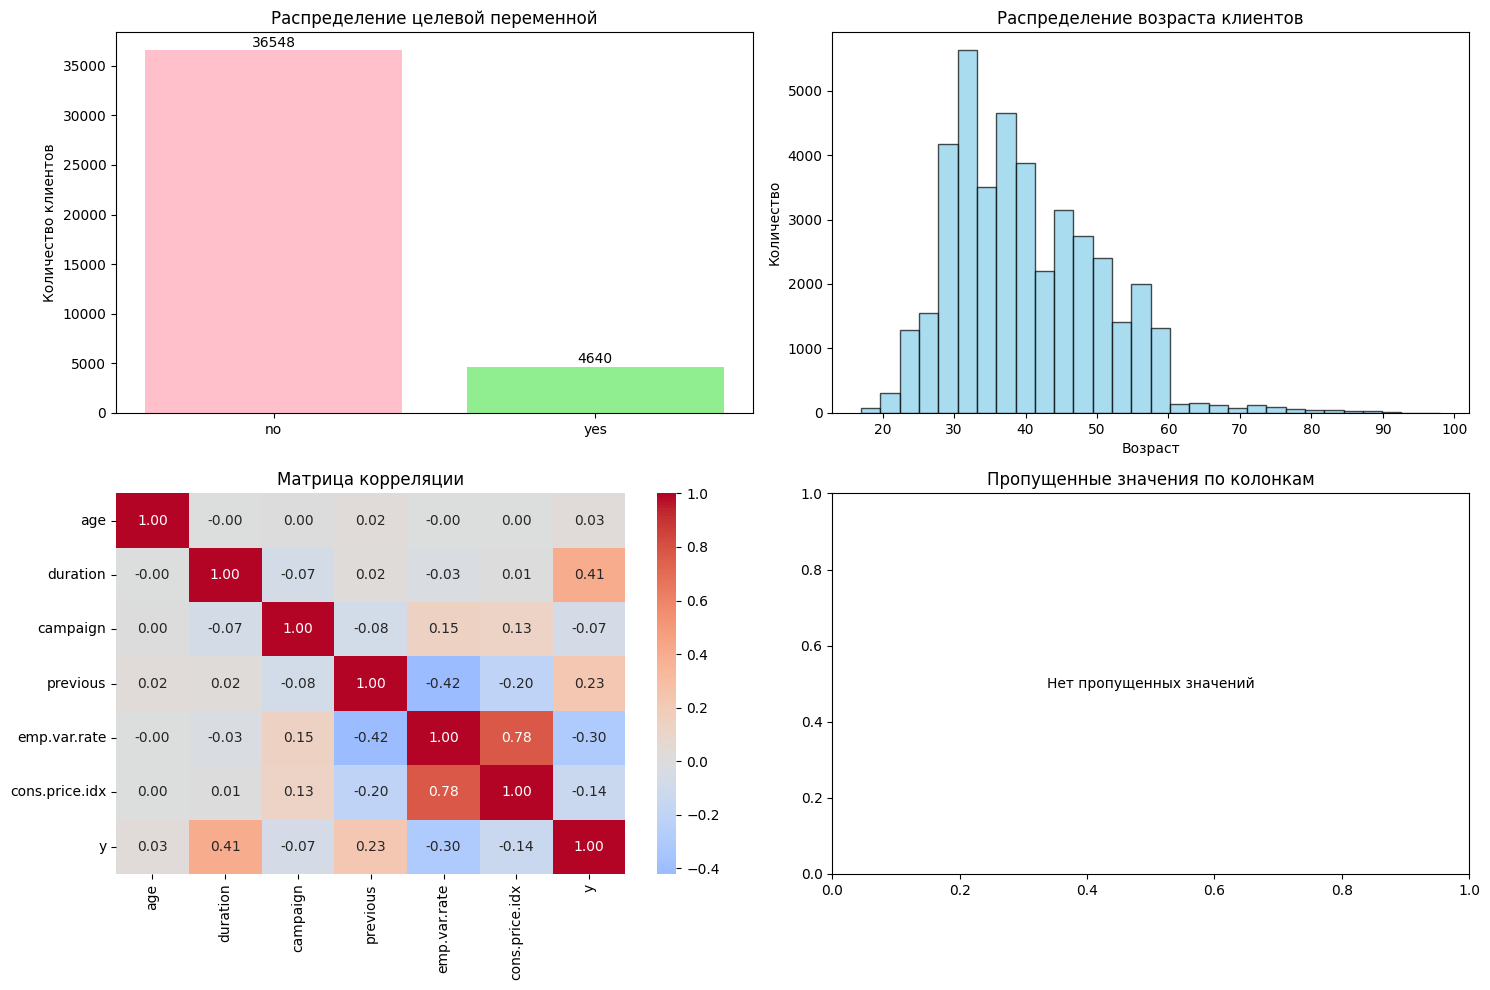


   Дополнительная статистика:
   Средний возраст: 40.0 лет
   Средняя продолжительность контакта: 258.3 сек
   Среднее количество контактов: 2.6


In [4]:
# @title Создаем визуализации для анализа данных таблицы raw_bank_marketing
# visualize_data

import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data(db_file='bank_marketing.db'):
    """Визуализация данных."""

    if not os.path.exists(db_file):
        print("Ошибка: База данных не найдена")
        return False

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query('SELECT * FROM raw_bank_marketing', conn)
        conn.close()

        # Анализ целевой переменной
        target_stats = df['y'].value_counts()
        total = len(df)
        print(f"   Всего записей: {total}")
        print(f"   Подписались (yes): {target_stats.get('yes', 0)} ({target_stats.get('yes', 0)/total*100:.1f}%)")
        print(f"   Не подписались (no): {target_stats.get('no', 0)} ({target_stats.get('no', 0)/total*100:.1f}%)")

        # Анализ пропущенных значений (NaN)
        nan_counts = df.isnull().sum()
        nan_counts = nan_counts[nan_counts > 0]
        if len(nan_counts) > 0:
            print("\n   Пропущенные значения (NaN):")
            for col, count in nan_counts.items():
                print(f"     {col}: {count} ({count/total*100:.1f}%)")

        # Создаем копию для визуализации
        df_viz = df.copy()

        plt.figure(figsize=(15, 10))

        # График 1: Распределение целевой переменной
        plt.subplot(2, 2, 1)
        plt.bar(target_stats.index, target_stats.values, color=['pink', 'lightgreen'])
        plt.title('Распределение целевой переменной')
        plt.ylabel('Количество клиентов')

        # Добавляем значения на столбцы
        for i, value in enumerate(target_stats.values):
            plt.text(i, value + 50, str(value), ha='center', va='bottom')

        # График 2: Распределение возраста
        plt.subplot(2, 2, 2)
        plt.hist(df_viz['age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Распределение возраста клиентов')
        plt.xlabel('Возраст')
        plt.ylabel('Количество')

        # График 3: Матрица корреляции
        plt.subplot(2, 2, 3)
        numeric_cols = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx']
        df_numeric = df_viz[numeric_cols].copy()

        # Создаем отдельную Series для целевой переменной
        y_numeric = df_viz['y'].map({'yes': 1, 'no': 0})
        df_numeric['y'] = y_numeric.values  # Используем .values для явного копирования

        correlation_matrix = df_numeric.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Матрица корреляции')

        # График 4: Пропущенные значения по колонкам
        plt.subplot(2, 2, 4)
        if len(nan_counts) > 0:
            nan_counts.plot(kind='bar', color='orange')
            plt.title('Пропущенные значения по колонкам')
            plt.ylabel('Количество пропусков')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'Нет пропущенных значений',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Пропущенные значения по колонкам')

        plt.tight_layout()
        plt.show()

        # Дополнительная статистика
        print("\n   Дополнительная статистика:")
        print(f"   Средний возраст: {df_viz['age'].mean():.1f} лет")
        print(f"   Средняя продолжительность контакта: {df_viz['duration'].mean():.1f} сек")
        print(f"   Среднее количество контактов: {df_viz['campaign'].mean():.1f}")

        return True

    except Exception as e:
        print(f"Ошибка при визуализации данных: {e}")
        return False

if __name__ == "__main__":
    print("\n" + "=" * 60)
    print("3. ВИЗУАЛИЗАЦИЯ ДАННЫХ ДАТАСЕТА")
    print("=" * 60)
    visualize_data()

In [5]:
# @title Проводим предобработку данных

import os
import pandas as pd
import numpy as np
import sqlite3
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler


def preprocess_data(db_file='bank_marketing.db'):
    """Предобработка данных и сохранение в базу данных."""
    print("Предобработка данных...")

    if not os.path.exists(db_file):
        print("Ошибка: База данных не найдена")
        return False

    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query('SELECT * FROM raw_bank_marketing', conn)

        # Создаем копию для обработки
        df_processed = df.copy()

        # Определяем типы колонок
        numerical_cols = [
            'age', 'duration', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
            'euribor3m', 'nr.employed'
        ]

        categorical_cols = [
            'job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome'
        ]

        target_col = 'y'


        # Преобразуем типы данных
        for col in numerical_cols:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')

        for col in categorical_cols + [target_col]:
            df_processed[col] = df_processed[col].astype(str)

        print(f"   Числовые колонки: {len(numerical_cols)}")
        print(f"   Категориальные колонки: {len(categorical_cols)}")

        # 1. Анализ пропущенных значений
        print("   Анализ пропущенных значений...")
        missing_counts = df_processed.isnull().sum()
        missing_counts = missing_counts[missing_counts > 0]

        if len(missing_counts) > 0:
            print("   Найдены пропущенные значения:")
            for col, count in missing_counts.items():
                percentage = (count / len(df_processed)) * 100
                print(f"     {col}: {count} пропусков ({percentage:.1f}%)")
        else:
            print("   Пропущенных значений не найдено")

        # 3. Кодирование категориальных признаков
        print("   Кодирование категориальных признаков...")

        encoders = {}
        for col in categorical_cols:
            encoder = LabelEncoder()
            encoded_values = encoder.fit_transform(df_processed[col])
            df_processed[col] = encoded_values
            encoders[col] = encoder
            print(f"     {col}: закодирован ({len(encoder.classes_)} категорий)")

        # 4. Кодирование целевой переменной
        df_processed[target_col] = df_processed[target_col].map({'yes': 1, 'no': 0})
        print("   Целевая переменная закодирована: yes=1, no=0")

        # 5. Масштабирование числовых признаков
        print("   Масштабирование числовых признаков...")

        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(df_processed[numerical_cols])
        df_processed[numerical_cols] = scaled_values

        print(f"     Масштабировано {len(numerical_cols)} числовых признаков")

        # Удаляем duration - продолжительность звонка из-за корреляции с целевой переменной
        print('Удаляем duration - продолжительность звонка из-за корреляции с целевой переменной')
        cols_to_drop = ['duration']
        for col in cols_to_drop:
            if col in df_processed.columns:
                df_processed.drop(col, axis=1, inplace=True)
                print(f"Удален столбец: {col}")


        # Сохраняем обработанные данные в базу
        print("   Сохранение обработанных данных в базу...")
        df_processed.to_sql('bank_marketing', conn, if_exists='replace', index=False)

        # Разделяем на признаки и целевую переменную
        X = df_processed.drop('y', axis=1)
        y = df_processed['y']

        print(f"   Данные подготовлены для ML:")
        print(f"     Признаки (X): {X.shape}")
        print(f"     Целевая переменная (y): {y.shape}")
        print(f"     Баланс классов: 0={sum(y==0)}, 1={sum(y==1)}")

        conn.close()
        return True

    except Exception as e:
        print(f"Ошибка при предобработке данных: {e}")
        import traceback
        traceback.print_exc()
        return False
if __name__ == "__main__":
    preprocess_data()

Предобработка данных...
   Числовые колонки: 10
   Категориальные колонки: 10
   Анализ пропущенных значений...
   Пропущенных значений не найдено
   Кодирование категориальных признаков...
     job: закодирован (12 категорий)
     marital: закодирован (4 категорий)
     education: закодирован (8 категорий)
     default: закодирован (3 категорий)
     housing: закодирован (3 категорий)
     loan: закодирован (3 категорий)
     contact: закодирован (2 категорий)
     month: закодирован (10 категорий)
     day_of_week: закодирован (5 категорий)
     poutcome: закодирован (3 категорий)
   Целевая переменная закодирована: yes=1, no=0
   Масштабирование числовых признаков...
     Масштабировано 10 числовых признаков
Удаляем duration - продолжительность звонка из-за корреляции с целевой переменной
Удален столбец: duration
   Сохранение обработанных данных в базу...
   Данные подготовлены для ML:
     Признаки (X): (41188, 19)
     Целевая переменная (y): (41188,)
     Баланс классов: 0=36548

In [6]:
# @title Визуализация результатов - сохраняем, вызываем в main
%%writefile result_visualization.py

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning


def plot_predictions(y_test, y_pred, model=None, feature_names=None):
    """
    Визуализация результатов предсказаний модели.

    Parameters:
    y_test: истинные значения (numpy array или pandas Series)
    y_pred: предсказанные значения (numpy array или pandas Series)
    model: обученная модель (для важности признаков)
    feature_names: названия признаков
    """
    # Конвертируем в numpy arrays для надежности
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    # Настройка стиля графиков
    plt.style.use('default')
    sns.set_palette("husl")

    # Создаем фигуру с subplots
    if model is not None and feature_names is not None:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        # Преобразуем axes в 2D массив для единообразия
        axes = np.array(axes).reshape(1, -1)

    fig.suptitle('Визуализация результатов классификации', fontsize=16, fontweight='bold')

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    if model is not None and feature_names is not None:
        ax_cm = axes[0, 0]
    else:
        ax_cm = axes[0, 0]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_title('Матрица ошибок (Confusion Matrix)')
    ax_cm.set_xlabel('Предсказанные значения')
    ax_cm.set_ylabel('Истинные значения')

    # 2. Распределение ошибок
    errors = (y_pred != y_test).astype(int)
    error_counts = pd.Series(errors).value_counts().sort_index()

    if model is not None and feature_names is not None:
        ax_pie = axes[0, 1]
    else:
        ax_pie = axes[0, 1]

    ax_pie.pie(error_counts.values, labels=['Правильные', 'Ошибки'],
               autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'],
               startangle=90)
    ax_pie.set_title('Распределение правильных и ошибочных предсказаний')

    # 3. Статистика по классам
    class_stats = pd.DataFrame({
        'Класс': ['Класс 0 (нет)', 'Класс 1 (да)'],
        'Истинные': [np.sum(y_test == 0), np.sum(y_test == 1)],
        'Предсказанные': [np.sum(y_pred == 0), np.sum(y_pred == 1)],
        'Правильные': [np.sum((y_test == 0) & (y_pred == 0)),
                       np.sum((y_test == 1) & (y_pred == 1))]
    })

    x = np.arange(len(class_stats))
    width = 0.25

    if model is not None and feature_names is not None:
        ax_bar = axes[1, 0]
    else:
        ax_bar = axes[0, 2]

    bars1 = ax_bar.bar(x - width, class_stats['Истинные'], width,
               label='Истинные', color='blue', alpha=0.7)
    bars2 = ax_bar.bar(x, class_stats['Предсказанные'], width,
               label='Предсказанные', color='orange', alpha=0.7)
    bars3 = ax_bar.bar(x + width, class_stats['Правильные'], width,
               label='Правильные', color='green', alpha=0.7)

    ax_bar.set_title('Статистика по классам')
    ax_bar.set_xlabel('Классы')
    ax_bar.set_ylabel('Количество')
    ax_bar.set_xticks(x)
    ax_bar.set_xticklabels(class_stats['Класс'])
    ax_bar.legend()

    # Добавляем значения на столбцы
    for i, (true_val, pred_val, correct_val) in enumerate(zip(
        class_stats['Истинные'], class_stats['Предсказанные'], class_stats['Правильные'])):
        ax_bar.text(i - width, true_val + 5, str(true_val), ha='center', fontsize=9)
        ax_bar.text(i, pred_val + 5, str(pred_val), ha='center', fontsize=9)
        ax_bar.text(i + width, correct_val + 5, str(correct_val), ha='center', fontsize=9)

    # 4. Визуализация важности признаков (если передана модель и названия признаков)
    if model is not None and feature_names is not None:
        plot_feature_importance_on_axis(model, feature_names, axes[1, 1])

    plt.tight_layout()
    plt.show()

    # Дополнительная информация
    accuracy = np.mean(y_pred == y_test)
    print(f"\nТочность модели: {accuracy:.4f}")
    print(f"Количество правильных предсказаний: {np.sum(y_pred == y_test)}/{len(y_test)}")
    print(f"Количество ошибок: {np.sum(y_pred != y_test)}/{len(y_test)}")


def plot_feature_importance_on_axis(model, feature_names, ax, top_n=15):
    """
    Визуализация важности признаков на указанной оси.
    """
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=True).tail(top_n)

        ax.barh(range(len(feature_imp_df)), feature_imp_df['importance'])
        ax.set_yticks(range(len(feature_imp_df)))
        ax.set_yticklabels(feature_imp_df['feature'])
        ax.set_title(f'Топ-{top_n} самых важных признаков')
        ax.set_xlabel('Важность признака')
        ax.grid(True, alpha=0.3)

        # Добавляем значения важности на график
        for i, v in enumerate(feature_imp_df['importance']):
            ax.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

        return feature_imp_df
    else:
        ax.text(0.5, 0.5, 'Модель не поддерживает\nатрибут feature_importances_',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Важность признаков')
        return None


def plot_feature_importance(model, feature_names, top_n=15):
    """
    Визуализация важности признаков в отдельном графике.
    """
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=True).tail(top_n)

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(feature_imp_df)), feature_imp_df['importance'])
        plt.yticks(range(len(feature_imp_df)), feature_imp_df['feature'])
        plt.title(f'Топ-{top_n} самых важных признаков')
        plt.xlabel('Важность признака')
        plt.grid(True, alpha=0.3)

        # Добавляем значения важности на график
        for i, v in enumerate(feature_imp_df['importance']):
            plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

        plt.tight_layout()
        plt.show()

        return feature_imp_df
    else:
        print("Модель не поддерживает атрибут feature_importances_")
        return None


def plot_roc_curve(y_test, y_pred_proba):
    """
    Построение ROC-кривой.
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC кривая (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Случайный классификатор')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc


def safe_classification_report(y_test, y_pred):
    """
    Безопасный вывод classification_report с обработкой UndefinedMetricWarning.
    """
    # Подавляем предупреждения UndefinedMetricWarning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        report = classification_report(y_test, y_pred, zero_division=0)

    return report


def safe_metrics_score(y_test, y_pred, metric_func, **kwargs):
    """
    Безопасный расчет метрик с обработкой UndefinedMetricWarning.
    """
    # Подавляем предупреждения UndefinedMetricWarning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        score = metric_func(y_test, y_pred, **kwargs)

    return score

Writing result_visualization.py


DUMMY CLASSIFIER - БАЗОВАЯ ЛИНИЯ

Загрузка данных...
Обучающая выборка: (28831, 19)
Тестовая выборка: (12357, 19)
Баланс классов в обучающей выборке:
  Класс 0 (нет): 25580 (88.72%)
  Класс 1 (да): 3251 (11.28%)

ТЕСТИРОВАНИЕ СТРАТЕГИЙ
ТЕСТИРОВАНИЕ СТРАТЕГИЙ DUMMY CLASSIFIER

Стратегия: most_frequent
  Точность: 0.8876
  F1-score: 0.8347

Стратегия: stratified
  Точность: 0.7992
  F1-score: 0.7986

Стратегия: uniform
  Точность: 0.5021
  F1-score: 0.5901

Стратегия: constant
  Константное значение: 0
  Точность: 0.8876
  F1-score: 0.8347

Лучшая стратегия: most_frequent (точность: 0.8876)

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

Визуализация для стратегии 'most_frequent':


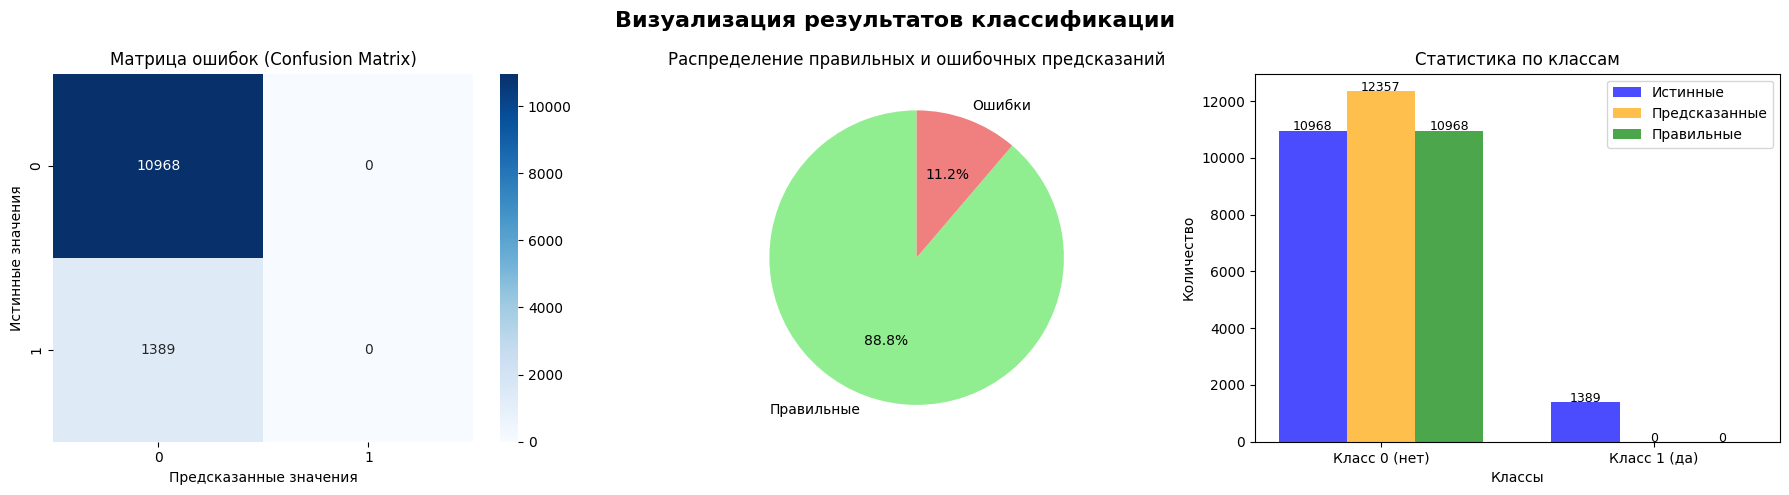


Точность модели: 0.8876
Количество правильных предсказаний: 10968/12357
Количество ошибок: 1389/12357

ОТЧЕТ КЛАССИФИКАЦИИ (most_frequent)
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10968
           1       0.00      0.00      0.00      1389

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.79      0.89      0.83     12357


СВОДНАЯ ТАБЛИЦА ВСЕХ СТРАТЕГИЙ
    Стратегия Точность F1-Score
most_frequent   0.8876   0.8347
   stratified   0.7992   0.7986
      uniform   0.5021   0.5901
     constant   0.8876   0.8347

ОБЪЯСНЕНИЕ СТРАТЕГИЙ
most_frequent: всегда предсказывает самый частый класс
stratified: случайные предсказания, сохраняя распределение классов
uniform: полностью случайные предсказания
constant: всегда предсказывает заданный класс

Dummy Classifier используется как базовая линия для сравнения.
Любая полезная модель должна превосходить эти

In [9]:
# @title Dummy Classifier - создадим базовые модели

import os
import pandas as pd
import sqlite3
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import result_visualization


def load_data(db_file='bank_marketing.db'):
    """Загрузка данных из БД"""
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query('SELECT * FROM bank_marketing', conn)
        conn.close()

        X = df.drop('y', axis=1)
        y = df['y']

        return X, y
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None


def test_dummy_strategies(X_train, X_test, y_train, y_test):
    """Тестирование разных стратегий Dummy Classifier"""
    strategies = ['most_frequent', 'stratified', 'uniform', 'constant']
    constant_value = 1 if np.sum(y_train) > len(y_train) / 2 else 0

    results = []

    print("ТЕСТИРОВАНИЕ СТРАТЕГИЙ DUMMY CLASSIFIER")
    print("=" * 50)

    for strategy in strategies:
        if strategy == 'constant':
            dummy = DummyClassifier(strategy=strategy, constant=constant_value)
        else:
            dummy = DummyClassifier(strategy=strategy, random_state=42)

        dummy.fit(X_train, y_train)
        y_pred = dummy.predict(X_test)

        # Используем безопасные функции для расчета метрик
        accuracy = accuracy_score(y_test, y_pred)
        f1 = result_visualization.safe_metrics_score(
            y_test, y_pred, f1_score, average='weighted'
        )

        results.append({
            'strategy': strategy,
            'accuracy': accuracy,
            'f1_score': f1,
            'model': dummy,
            'predictions': y_pred
        })

        print(f"\nСтратегия: {strategy}")
        if strategy == 'constant':
            print(f"  Константное значение: {constant_value}")
        print(f"  Точность: {accuracy:.4f}")
        print(f"  F1-score: {f1:.4f}")

    return results


def main():
    """Основная функция программы."""
    print("DUMMY CLASSIFIER - БАЗОВАЯ ЛИНИЯ")
    print("=" * 50)

    try:
        # Загрузка данных
        print("\nЗагрузка данных...")
        X, y = load_data()

        if X is None or y is None:
            print("Не удалось загрузить данные")
            return

        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        print(f"Обучающая выборка: {X_train.shape}")
        print(f"Тестовая выборка: {X_test.shape}")
        print(f"Баланс классов в обучающей выборке:")
        print(f"  Класс 0 (нет): {np.sum(y_train == 0)} ({np.mean(y_train == 0):.2%})")
        print(f"  Класс 1 (да): {np.sum(y_train == 1)} ({np.mean(y_train == 1):.2%})")

        # Тестирование разных стратегий Dummy Classifier
        print("\n" + "=" * 60)
        print("ТЕСТИРОВАНИЕ СТРАТЕГИЙ")
        print("=" * 60)

        results = test_dummy_strategies(X_train, X_test, y_train, y_test)

        # Выбираем лучшую стратегию
        best_result = max(results, key=lambda x: x['accuracy'])
        print(f"\nЛучшая стратегия: {best_result['strategy']} "
              f"(точность: {best_result['accuracy']:.4f})")

        # Визуализация результатов лучшей стратегии
        print("\n" + "=" * 60)
        print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
        print("=" * 60)

        print(f"\nВизуализация для стратегии '{best_result['strategy']}':")
        result_visualization.plot_predictions(y_test, best_result['predictions'])

        # Детальный отчет для лучшей стратегии (без предупреждений)
        print("\n" + "=" * 40)
        print(f"ОТЧЕТ КЛАССИФИКАЦИИ ({best_result['strategy']})")
        print("=" * 40)
        report = result_visualization.safe_classification_report(y_test, best_result['predictions'])
        print(report)

        # Сводная таблица всех стратегий
        print("\n" + "=" * 50)
        print("СВОДНАЯ ТАБЛИЦА ВСЕХ СТРАТЕГИЙ")
        print("=" * 50)

        summary_df = pd.DataFrame([
            {
                'Стратегия': r['strategy'],
                'Точность': f"{r['accuracy']:.4f}",
                'F1-Score': f"{r['f1_score']:.4f}"
            }
            for r in results
        ])
        print(summary_df.to_string(index=False))

        # Объяснение стратегий
        print("\n" + "=" * 40)
        print("ОБЪЯСНЕНИЕ СТРАТЕГИЙ")
        print("=" * 40)
        print("most_frequent: всегда предсказывает самый частый класс")
        print("stratified: случайные предсказания, сохраняя распределение классов")
        print("uniform: полностью случайные предсказания")
        print("constant: всегда предсказывает заданный класс")
        print("\nDummy Classifier используется как базовая линия для сравнения.")
        print("Любая полезная модель должна превосходить эти простые стратегии.")

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")


if __name__ == "__main__":
    main()

LOGISTIC REGRESSION CLASSIFIER

Загрузка данных...
Обучающая выборка: (28831, 19)
Тестовая выборка: (12357, 19)
Баланс классов в обучающей выборке:
  Класс 0 (нет): 25580 (88.72%)
  Класс 1 (да): 3251 (11.28%)

Масштабирование признаков...
Признаки успешно масштабированы

ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ
ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ LOGISTIC REGRESSION

Конфигурация 1:
  C: 0.1
  penalty: l2
  solver: lbfgs
  Точность: 0.8999
  F1-score: 0.8769
  Сходимость: Да

Конфигурация 2:
  C: 1.0
  penalty: l2
  solver: lbfgs
  Точность: 0.9001
  F1-score: 0.8772
  Сходимость: Да

Конфигурация 3:
  C: 10.0
  penalty: l2
  solver: lbfgs
  Точность: 0.9003
  F1-score: 0.8775
  Сходимость: Да

Конфигурация 4:
  C: 100.0
  penalty: l2
  solver: lbfgs
  Точность: 0.9003
  F1-score: 0.8775
  Сходимость: Да

Конфигурация 5:
  C: 1.0
  penalty: l1
  solver: liblinear
  Точность: 0.9001
  F1-score: 0.8772
  Сходимость: Да

Конфигурация 6:
  C: 1.0
  penalty: l2
  solver: liblinear
  Точность: 0.9001
  F1-score: 0.

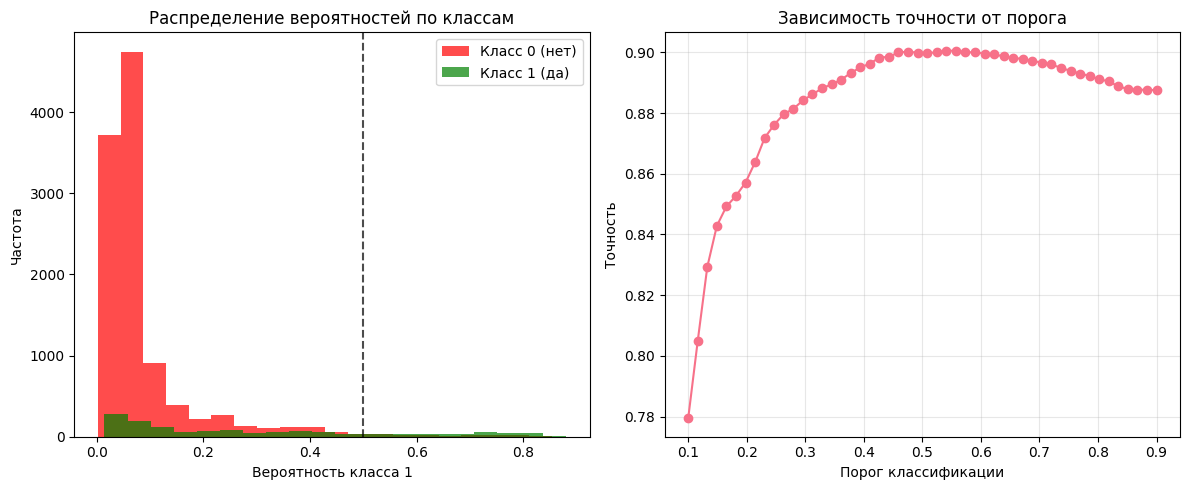


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ

Визуализация для лучшей конфигурации Logistic Regression:


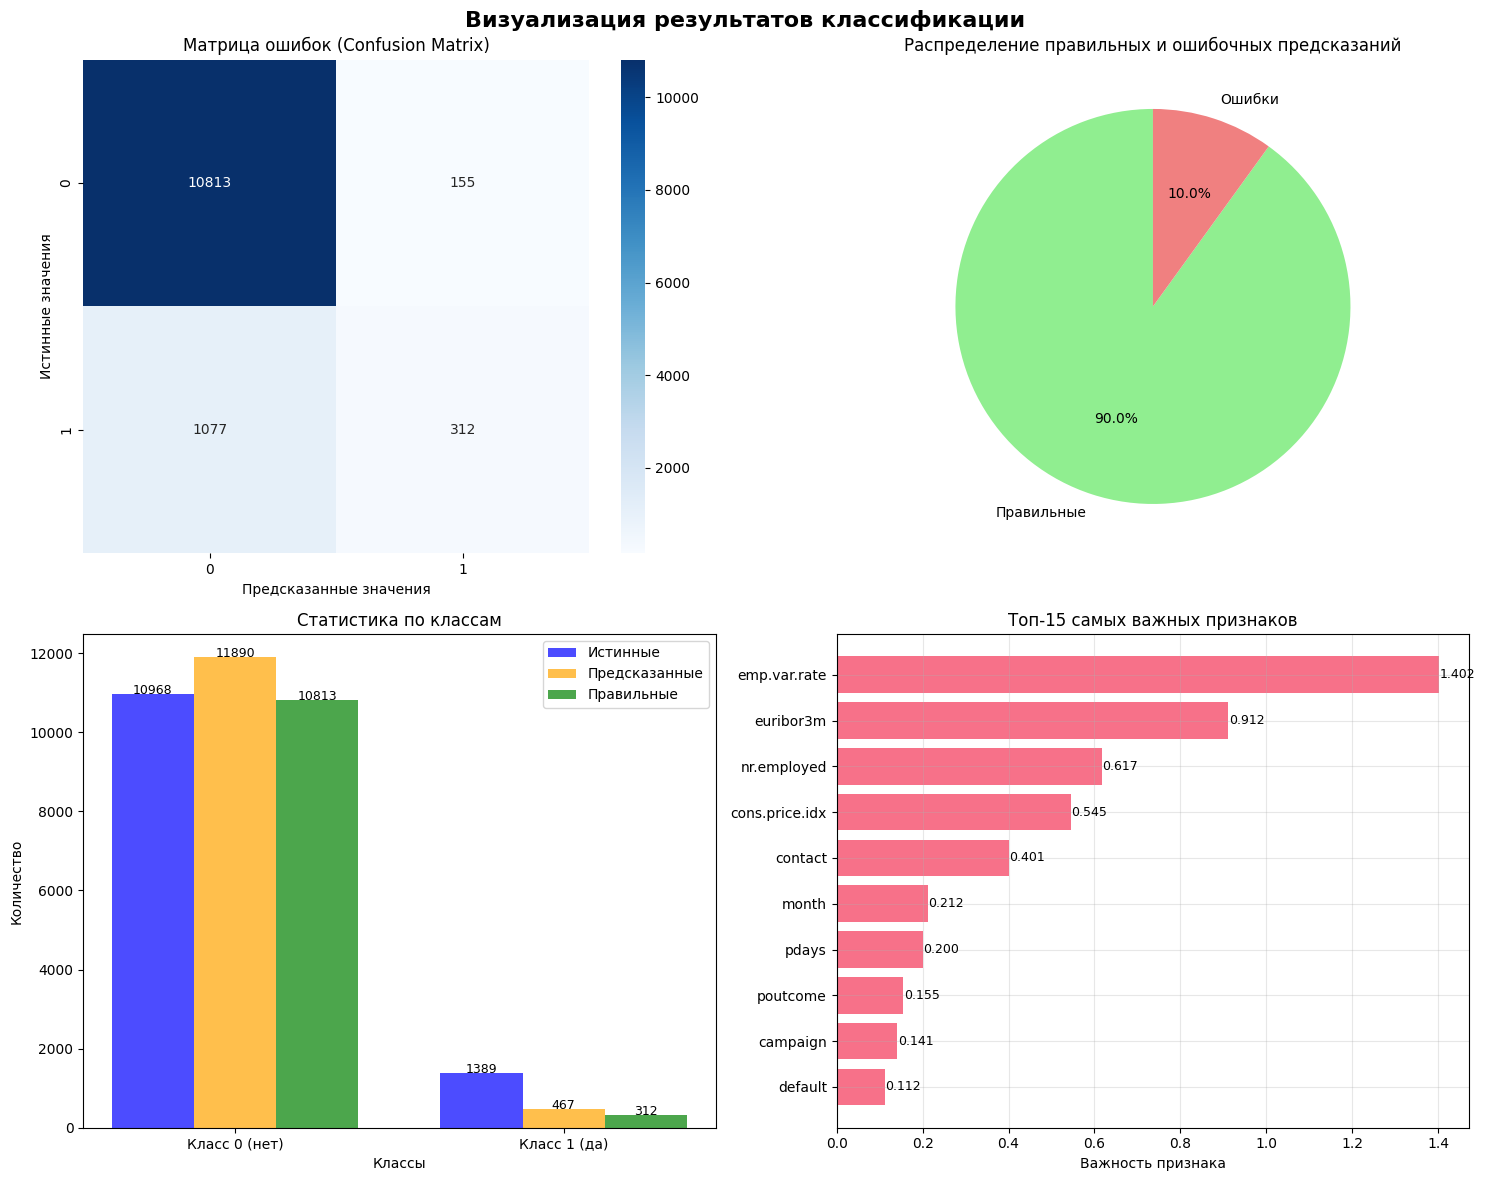


Точность модели: 0.9003
Количество правильных предсказаний: 11125/12357
Количество ошибок: 1232/12357

ОТЧЕТ КЛАССИФИКАЦИИ (LOGISTIC REGRESSION)
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10968
           1       0.67      0.22      0.34      1389

    accuracy                           0.90     12357
   macro avg       0.79      0.61      0.64     12357
weighted avg       0.88      0.90      0.88     12357


СВОДНАЯ ТАБЛИЦА КОНФИГУРАЦИЙ
 Конфиг     C                    penalty    solver Точность F1-Score
      1   0.1                         l2     lbfgs   0.8999   0.8769
      2   1.0                         l2     lbfgs   0.9001   0.8772
      3  10.0                         l2     lbfgs   0.9003   0.8775
      4 100.0                         l2     lbfgs   0.9003   0.8775
      5   1.0                         l1 liblinear   0.9001   0.8772
      6   1.0                         l2 liblinear   0.9001   0.8772
      7   1.0 

In [2]:
# @title Logistic Regression

import os
import pandas as pd
import sqlite3
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import result_visualization


def load_data(db_file='bank_marketing.db'):
    """Загрузка данных из БД"""
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query('SELECT * FROM bank_marketing', conn)
        conn.close()

        X = df.drop('y', axis=1)
        y = df['y']

        return X, y
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None


def scale_features(X_train, X_test):
    """Масштабирование признаков для Logistic Regression"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler


def test_logistic_regression_configurations(X_train, X_test, y_train, y_test):
    """Тестирование разных конфигураций Logistic Regression"""
    configurations = [
        {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000},
        {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000},
        {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000},
        {'C': 100.0, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 1000},
        {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 1000},
        {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 1000},
        {'C': 1.0, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 1000},
        {'C': 1.0, 'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5, 'max_iter': 1000},
    ]

    results = []

    print("ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ LOGISTIC REGRESSION")
    print("=" * 65)

    for i, config in enumerate(configurations, 1):
        print(f"\nКонфигурация {i}:")
        print(f"  C: {config['C']}")
        print(f"  penalty: {config['penalty']}")
        print(f"  solver: {config['solver']}")

        if config['penalty'] == 'elasticnet':
            print(f"  l1_ratio: {config['l1_ratio']}")

        # Создаем модель Logistic Regression
        lr_model = LogisticRegression(
            C=config['C'],
            penalty=config['penalty'],
            solver=config['solver'],
            max_iter=config['max_iter'],
            random_state=42,
            l1_ratio=config.get('l1_ratio', None)
        )

        # Обучаем модель
        lr_model.fit(X_train, y_train)

        # Предсказания
        y_pred = lr_model.predict(X_test)
        y_pred_proba = lr_model.predict_proba(X_test)[:, 1]  # Вероятности класса 1

        # Метрики
        accuracy = accuracy_score(y_test, y_pred)
        f1 = result_visualization.safe_metrics_score(
            y_test, y_pred, f1_score, average='weighted'
        )

        results.append({
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'model': lr_model,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        })

        print(f"  Точность: {accuracy:.4f}")
        print(f"  F1-score: {f1:.4f}")
        print(f"  Сходимость: {'Да' if lr_model.n_iter_ < config['max_iter'] else 'Нет'}")

    return results


def analyze_logistic_regression_model(model, feature_names, X_test, y_test, y_pred_proba):
    """Детальный анализ Logistic Regression модели"""
    print(f"\nДетальный анализ Logistic Regression модели:")

    # Коэффициенты и интерпретация
    coefficients = model.coef_[0]
    intercept = model.intercept_[0]

    print(f"  Свободный член (intercept): {intercept:.4f}")
    print(f"  Количество признаков: {len(coefficients)}")

    # Анализ коэффициентов
    coef_df = pd.DataFrame({
        'Признак': feature_names,
        'Коэффициент': coefficients,
        'Влияние': ['Положительное' if coef > 0 else 'Отрицательное' for coef in coefficients],
        '|Коэффициент|': np.abs(coefficients)
    }).sort_values('|Коэффициент|', ascending=False).head(10)

    print(f"\nТоп-10 самых влиятельных признаков:")
    for _, row in coef_df.iterrows():
        effect = "увеличивает" if row['Коэффициент'] > 0 else "уменьшает"
        print(f"  {row['Признак']}: {row['Коэффициент']:.4f} ({effect} вероятность класса 1)")

    # Анализ вероятностей
    print(f"\nАнализ вероятностей предсказаний:")
    print(f"  Минимальная вероятность: {y_pred_proba.min():.4f}")
    print(f"  Максимальная вероятность: {y_pred_proba.max():.4f}")
    print(f"  Средняя вероятность: {y_pred_proba.mean():.4f}")

    # Распределение вероятностей по порогам
    thresholds = [0.3, 0.5, 0.7]
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        accuracy = accuracy_score(y_test, y_pred_threshold)
        print(f"  Точность при пороге {threshold}: {accuracy:.4f}")

    return coef_df


def plot_probability_distribution(y_pred_proba, y_test):
    """Визуализация распределения вероятностей"""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Распределение вероятностей по классам
    plt.subplot(1, 2, 1)
    plt.hist(y_pred_proba[y_test == 0], bins=20, alpha=0.7, label='Класс 0 (нет)', color='red')
    plt.hist(y_pred_proba[y_test == 1], bins=20, alpha=0.7, label='Класс 1 (да)', color='green')
    plt.xlabel('Вероятность класса 1')
    plt.ylabel('Частота')
    plt.title('Распределение вероятностей по классам')
    plt.legend()
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7)

    # Кривая точности по порогам
    plt.subplot(1, 2, 2)
    thresholds = np.linspace(0.1, 0.9, 50)
    accuracies = []
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred_threshold))

    plt.plot(thresholds, accuracies, marker='o')
    plt.xlabel('Порог классификации')
    plt.ylabel('Точность')
    plt.title('Зависимость точности от порога')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def main():
    """Основная функция программы."""
    print("LOGISTIC REGRESSION CLASSIFIER")
    print("=" * 45)

    try:
        # Загрузка данных
        print("\nЗагрузка данных...")
        X, y = load_data()

        if X is None or y is None:
            print("Не удалось загрузить данные")
            return

        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        print(f"Обучающая выборка: {X_train.shape}")
        print(f"Тестовая выборка: {X_test.shape}")
        print(f"Баланс классов в обучающей выборке:")
        print(f"  Класс 0 (нет): {np.sum(y_train == 0)} ({np.mean(y_train == 0):.2%})")
        print(f"  Класс 1 (да): {np.sum(y_train == 1)} ({np.mean(y_train == 1):.2%})")

        # Масштабирование признаков для Logistic Regression
        print("\nМасштабирование признаков...")
        X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
        print("Признаки успешно масштабированы")

        # Тестирование разных конфигураций Logistic Regression
        print("\n" + "=" * 60)
        print("ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ")
        print("=" * 60)

        results = test_logistic_regression_configurations(X_train_scaled, X_test_scaled, y_train, y_test)

        # Выбираем лучшую конфигурацию
        best_result = max(results, key=lambda x: x['accuracy'])
        print(f"\nЛучшая конфигурация:")
        config = best_result['config']
        print(f"  C: {config['C']}")
        print(f"  penalty: {config['penalty']}")
        print(f"  solver: {config['solver']}")

        if config['penalty'] == 'elasticnet':
            print(f"  l1_ratio: {config['l1_ratio']}")

        print(f"  Точность: {best_result['accuracy']:.4f}")

        # Детальный анализ лучшей модели
        coef_df = analyze_logistic_regression_model(
            best_result['model'],
            X.columns.tolist(),
            X_test_scaled,
            y_test,
            best_result['probabilities']
        )

        # Визуализация распределения вероятностей
        print("\n" + "=" * 50)
        print("ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ ВЕРОЯТНОСТЕЙ")
        print("=" * 50)
        plot_probability_distribution(best_result['probabilities'], y_test)

        # Визуализация результатов классификации
        print("\n" + "=" * 60)
        print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ")
        print("=" * 60)

        print(f"\nВизуализация для лучшей конфигурации Logistic Regression:")

        # Logistic Regression не имеет feature_importances_, но можем передать коэффициенты
        # Создаем временную модель для визуализации важности признаков
        class TempModel:
            def __init__(self, coef_df):
                self.feature_importances_ = np.abs(coef_df['Коэффициент'].values)

        temp_model = TempModel(coef_df)

        result_visualization.plot_predictions(
            y_test,
            best_result['predictions'],
            model=temp_model,
            feature_names=coef_df['Признак'].head(15).tolist()  # Только топ-15 признаков
        )

        # Детальный отчет для лучшей конфигурации
        print("\n" + "=" * 40)
        print("ОТЧЕТ КЛАССИФИКАЦИИ (LOGISTIC REGRESSION)")
        print("=" * 40)
        report = result_visualization.safe_classification_report(y_test, best_result['predictions'])
        print(report)

        # Сводная таблица всех конфигураций
        print("\n" + "=" * 80)
        print("СВОДНАЯ ТАБЛИЦА КОНФИГУРАЦИЙ")
        print("=" * 80)

        summary_data = []
        for i, result in enumerate(results, 1):
            config = result['config']

            penalty_info = config['penalty']
            if config['penalty'] == 'elasticnet':
                penalty_info += f" (l1_ratio: {config['l1_ratio']})"

            summary_data.append({
                'Конфиг': i,
                'C': config['C'],
                'penalty': penalty_info,
                'solver': config['solver'],
                'Точность': f"{result['accuracy']:.4f}",
                'F1-Score': f"{result['f1_score']:.4f}"
            })

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

        # Объяснение метода Logistic Regression
        print("\n" + "=" * 40)
        print("О МЕТОДЕ LOGISTIC REGRESSION")
        print("=" * 40)
        print("Logistic Regression - это классический метод, который:")
        print("Моделирует вероятность принадлежности к классу")
        print("Использует логистическую (сигмоидную) функцию")
        print("Ключевые параметры:")
        print("C: обратная сила регуляризации (меньше C = больше регуляризация)")
        print("penalty: тип регуляризации (l1, l2, elasticnet)")
        print("solver: алгоритм оптимизации")
        print("Преимущества: интерпретируемость, вероятности, быстродействие")
        print("Недостатки: линейные границы, требует масштабирования")

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")


if __name__ == "__main__":
    main()

DECISION TREE CLASSIFIER

Загрузка данных...
Обучающая выборка: (28831, 19)
Тестовая выборка: (12357, 19)
Баланс классов в обучающей выборке:
  Класс 0 (нет): 25580 (88.72%)
  Класс 1 (да): 3251 (11.28%)

ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ
ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ DECISION TREE

Конфигурация 1:
  criterion: gini
  max_depth: 3
  min_samples_split: 2
  Точность: 0.8992
  F1-score: 0.8728

Конфигурация 2:
  criterion: gini
  max_depth: 5
  min_samples_split: 2
  Точность: 0.8998
  F1-score: 0.8804

Конфигурация 3:
  criterion: gini
  max_depth: 7
  min_samples_split: 2
  Точность: 0.8990
  F1-score: 0.8799

Конфигурация 4:
  criterion: gini
  max_depth: 10
  min_samples_split: 2
  Точность: 0.8941
  F1-score: 0.8775

Конфигурация 5:
  criterion: gini
  max_depth: None
  min_samples_split: 2
  Точность: 0.8343
  F1-score: 0.8393

Конфигурация 6:
  criterion: entropy
  max_depth: 5
  min_samples_split: 2
  Точность: 0.8999
  F1-score: 0.8791

Конфигурация 7:
  criterion: gini
  max_depth: 5
  min_

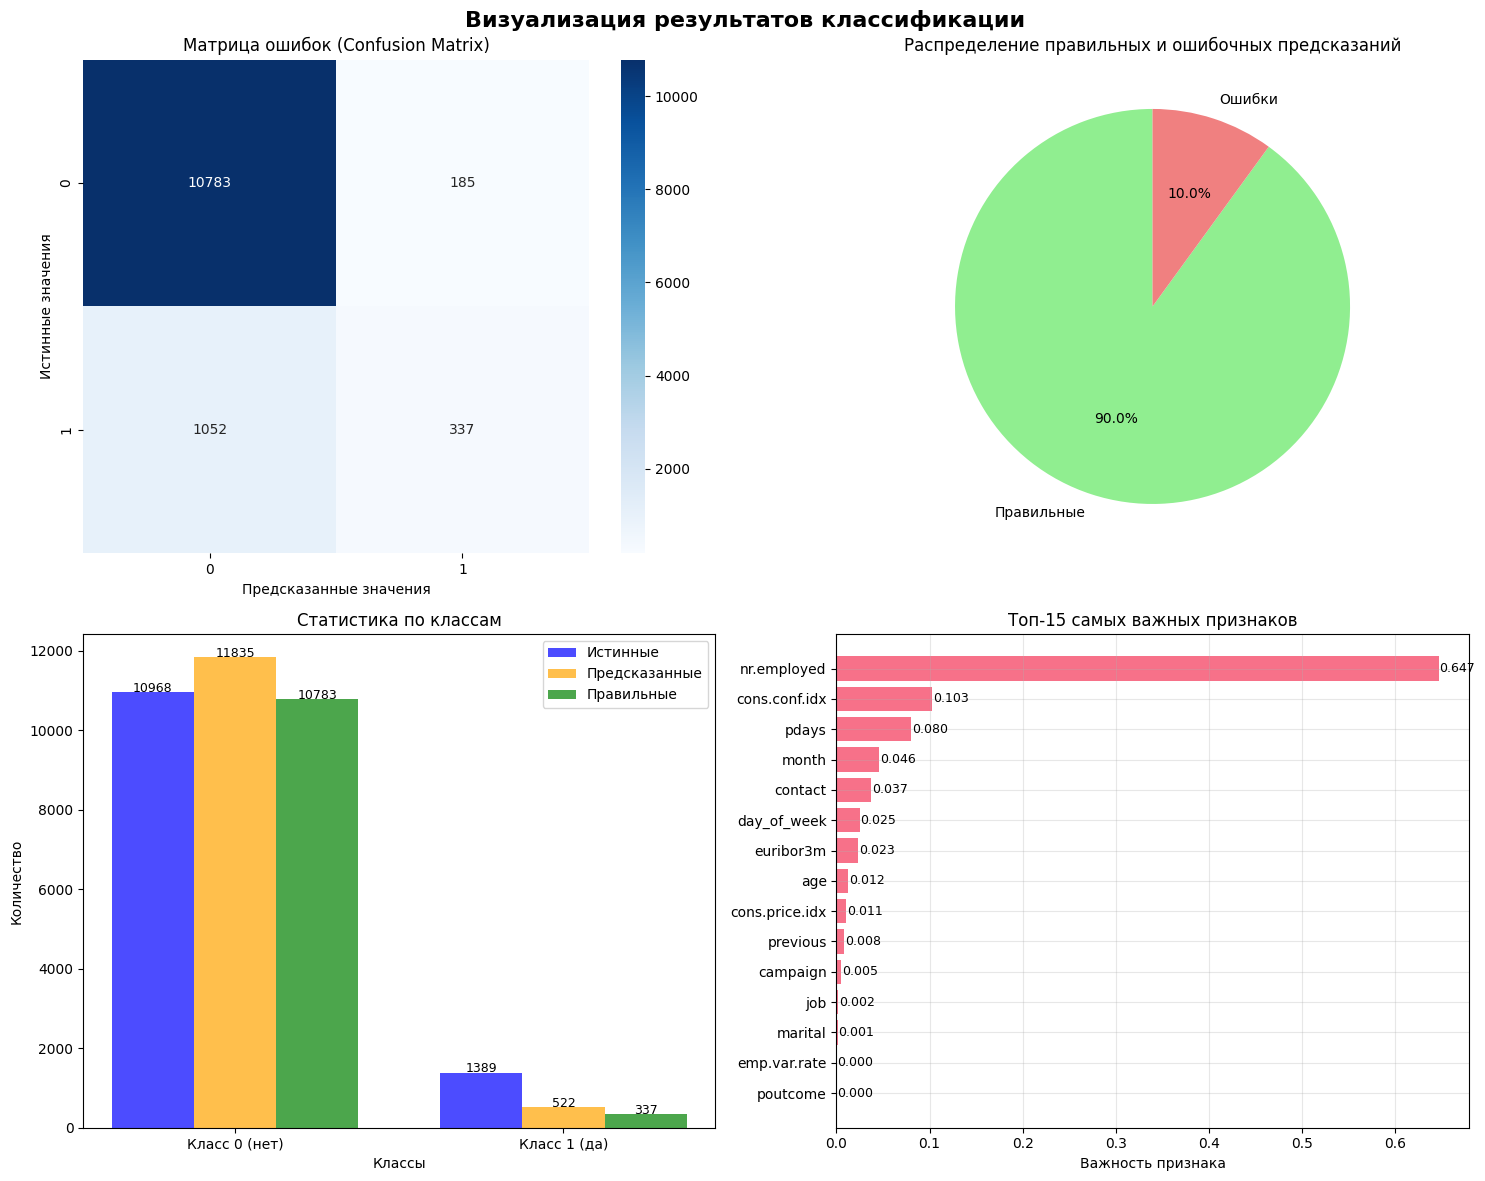


Точность модели: 0.8999
Количество правильных предсказаний: 11120/12357
Количество ошибок: 1237/12357

ОТЧЕТ КЛАССИФИКАЦИИ (DECISION TREE)
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10968
           1       0.65      0.24      0.35      1389

    accuracy                           0.90     12357
   macro avg       0.78      0.61      0.65     12357
weighted avg       0.88      0.90      0.88     12357


СВОДНАЯ ТАБЛИЦА КОНФИГУРАЦИЙ
 Конфиг criterion  max_depth  min_samples_split Точность F1-Score
      1      gini        3.0                  2   0.8992   0.8728
      2      gini        5.0                  2   0.8998   0.8804
      3      gini        7.0                  2   0.8990   0.8799
      4      gini       10.0                  2   0.8941   0.8775
      5      gini        NaN                  2   0.8343   0.8393
      6   entropy        5.0                  2   0.8999   0.8791
      7      gini        5.0             

In [3]:
# @title Decision Tree Classifier

import os
import pandas as pd
import sqlite3
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import result_visualization


def load_data(db_file='bank_marketing.db'):
    """Загрузка данных из БД"""
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query('SELECT * FROM bank_marketing', conn)
        conn.close()

        X = df.drop('y', axis=1)
        y = df['y']

        return X, y
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None


def test_decision_tree_configurations(X_train, X_test, y_train, y_test):
    """Тестирование разных конфигураций Decision Tree"""
    configurations = [
        {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2},
        {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2},
        {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2},
        {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2},
        {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2},
        {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2},
        {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5},
        {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10},
    ]

    results = []

    print("ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ DECISION TREE")
    print("=" * 55)

    for i, config in enumerate(configurations, 1):
        print(f"\nКонфигурация {i}:")
        print(f"  criterion: {config['criterion']}")
        print(f"  max_depth: {config['max_depth']}")
        print(f"  min_samples_split: {config['min_samples_split']}")

        # Создаем модель Decision Tree
        dt_model = DecisionTreeClassifier(
            criterion=config['criterion'],
            max_depth=config['max_depth'],
            min_samples_split=config['min_samples_split'],
            random_state=42
        )

        # Обучаем модель
        dt_model.fit(X_train, y_train)

        # Предсказания
        y_pred = dt_model.predict(X_test)

        # Метрики
        accuracy = accuracy_score(y_test, y_pred)
        f1 = result_visualization.safe_metrics_score(
            y_test, y_pred, f1_score, average='weighted'
        )

        results.append({
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'model': dt_model,
            'predictions': y_pred
        })

        print(f"  Точность: {accuracy:.4f}")
        print(f"  F1-score: {f1:.4f}")

    return results


def analyze_tree_structure(model, feature_names):
    """Анализ структуры дерева"""
    n_nodes = model.tree_.node_count
    n_leaves = model.tree_.n_leaves
    max_depth = model.get_depth()

    print(f"\nСтруктура дерева:")
    print(f"  Всего узлов: {n_nodes}")
    print(f"  Листьев: {n_leaves}")
    print(f"  Глубина дерева: {max_depth}")

    # Важность признаков
    if hasattr(model, 'feature_importances_'):
        print(f"\nТоп-5 самых важных признаков:")
        feature_imp = pd.DataFrame({
            'Признак': feature_names,
            'Важность': model.feature_importances_
        }).sort_values('Важность', ascending=False).head(5)

        for _, row in feature_imp.iterrows():
            print(f"  {row['Признак']}: {row['Важность']:.4f}")


def main():
    """Основная функция программы."""
    print("DECISION TREE CLASSIFIER")
    print("=" * 40)

    try:
        # Загрузка данных
        print("\nЗагрузка данных...")
        X, y = load_data()

        if X is None or y is None:
            print("Не удалось загрузить данные")
            return

        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        print(f"Обучающая выборка: {X_train.shape}")
        print(f"Тестовая выборка: {X_test.shape}")
        print(f"Баланс классов в обучающей выборке:")
        print(f"  Класс 0 (нет): {np.sum(y_train == 0)} ({np.mean(y_train == 0):.2%})")
        print(f"  Класс 1 (да): {np.sum(y_train == 1)} ({np.mean(y_train == 1):.2%})")

        # Тестирование разных конфигураций Decision Tree
        print("\n" + "=" * 60)
        print("ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ")
        print("=" * 60)

        results = test_decision_tree_configurations(X_train, X_test, y_train, y_test)

        # Выбираем лучшую конфигурацию
        best_result = max(results, key=lambda x: x['accuracy'])
        print(f"\nЛучшая конфигурация:")
        config = best_result['config']
        print(f"  criterion: {config['criterion']}")
        print(f"  max_depth: {config['max_depth']}")
        print(f"  min_samples_split: {config['min_samples_split']}")
        print(f"  Точность: {best_result['accuracy']:.4f}")

        # Анализ структуры лучшего дерева
        analyze_tree_structure(best_result['model'], X.columns.tolist())

        # Визуализация результатов лучшей конфигурации
        print("\n" + "=" * 60)
        print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
        print("=" * 60)

        print(f"\nВизуализация для лучшей конфигурации Decision Tree:")
        result_visualization.plot_predictions(
            y_test,
            best_result['predictions'],
            model=best_result['model'],
            feature_names=X.columns.tolist()
        )

        # Детальный отчет для лучшей конфигурации
        print("\n" + "=" * 40)
        print("ОТЧЕТ КЛАССИФИКАЦИИ (DECISION TREE)")
        print("=" * 40)
        report = result_visualization.safe_classification_report(y_test, best_result['predictions'])
        print(report)

        # Сводная таблица всех конфигураций
        print("\n" + "=" * 70)
        print("СВОДНАЯ ТАБЛИЦА КОНФИГУРАЦИЙ")
        print("=" * 70)

        summary_data = []
        for i, result in enumerate(results, 1):
            config = result['config']

            summary_data.append({
                'Конфиг': i,
                'criterion': config['criterion'],
                'max_depth': config['max_depth'],
                'min_samples_split': config['min_samples_split'],
                'Точность': f"{result['accuracy']:.4f}",
                'F1-Score': f"{result['f1_score']:.4f}"
            })

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

        # Анализ переобучения
        print("\n" + "=" * 50)
        print("АНАЛИЗ ПЕРЕОБУЧЕНИЯ")
        print("=" * 50)

        # Сравнение accuracy на train и test для лучшей модели
        train_accuracy = accuracy_score(y_train, best_result['model'].predict(X_train))
        test_accuracy = best_result['accuracy']

        print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
        print(f"Точность на тестовой выборке:  {test_accuracy:.4f}")
        print(f"Разница: {train_accuracy - test_accuracy:.4f}")

        if train_accuracy - test_accuracy > 0.1:
            print("Внимание: возможное переобучение!")
        elif train_accuracy - test_accuracy < 0.02:
            print("Модель хорошо обобщает")
        else:
            print("Умеренное расхождение в точности")

        # Объяснение метода Decision Tree
        print("\n" + "=" * 40)
        print("О МЕТОДЕ DECISION TREE")
        print("=" * 40)
        print("Decision Tree (Дерево решений) - это метод, который:")
        print("Строит древовидную структуру решений")
        print("Разделяет данные по признакам, максимизируя информативность")
        print("Критерии разделения: gini (неоднородность) или entropy (энтропия)")
        print("Параметры контроля:")
        print("max_depth: максимальная глубина дерева")
        print("min_samples_split: минимальное samples для разделения узла")
        print("Преимущества: интерпретируемость, работает с категориальными данными")
        print("Недостатки: склонность к переобучению")

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")


if __name__ == "__main__":
    main()

ОБРАБОТКА ДАННЫХ БАНКОВСКОГО МАРКЕТИНГА

ПОСТРОЕНИЕ МОДЕЛИ ML
Обучающая выборка: (28831, 19)
Тестовая выборка: (12357, 19)
Обучение модели...


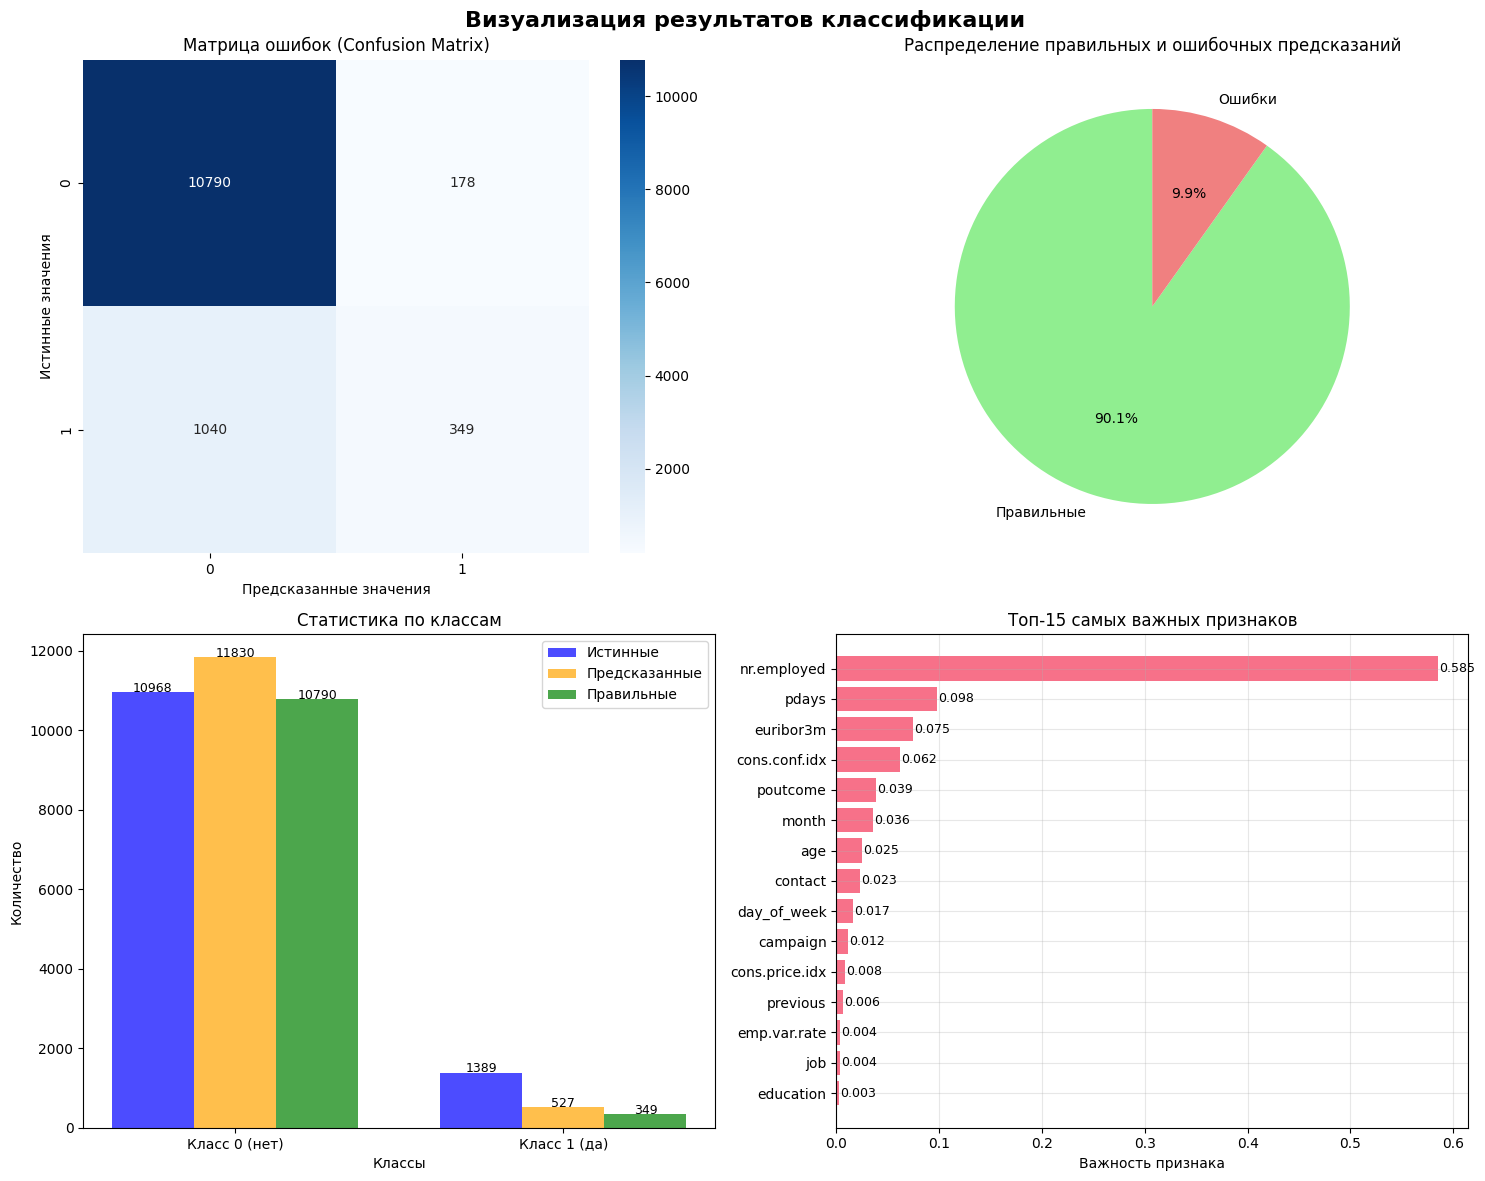


Точность модели: 0.9014
Количество правильных предсказаний: 11139/12357
Количество ошибок: 1218/12357

ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10968
           1       0.66      0.25      0.36      1389

    accuracy                           0.90     12357
   macro avg       0.79      0.62      0.66     12357
weighted avg       0.88      0.90      0.88     12357

Модель сохранена в файл 'gradient_boosting_model.pkl'


In [7]:
# @title GradientBoostingClassifier

import os
import pandas as pd
import sqlite3
import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import result_visualization


def load_data(db_file='bank_marketing.db'):
    """Загрузка данных из БД"""
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query('SELECT * FROM bank_marketing', conn)
        conn.close()

        X = df.drop('y', axis=1)
        y = df['y']

        return X, y
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None


def main():
    """Основная функция программы."""
    print("ОБРАБОТКА ДАННЫХ БАНКОВСКОГО МАРКЕТИНГА")
    print("=" * 50)

    try:
        #  ПОСТРОЕНИЕ МОДЕЛИ ML GradientBoostingClassifier
        print("\n" + "=" * 60)
        print("ПОСТРОЕНИЕ МОДЕЛИ ML")
        print("=" * 60)
        X, y = load_data()

        if X is None or y is None:
            print("Не удалось загрузить данные")
            return

        # Разделение данных на обучающий и тестовый наборы
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        print(f"Обучающая выборка: {X_train.shape}")
        print(f"Тестовая выборка: {X_test.shape}")

        # Создание и обучение модели
        gb_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

        print("Обучение модели...")
        gb_classifier.fit(X_train, y_train)

        # Предсказание
        y_pred = gb_classifier.predict(X_test)

        # Визуализация с важностью признаков
        result_visualization.plot_predictions(y_test, y_pred,
                                            model=gb_classifier,
                                            feature_names=X.columns.tolist())

        # Вывод отчета классификации
        print("\nОТЧЕТ КЛАССИФИКАЦИИ:")
        print("=" * 40)
        report = classification_report(y_test, y_pred)
        print(report)

        # Сохранение модели
        joblib.dump(gb_classifier, 'gradient_boosting_model.pkl')
        print("Модель сохранена в файл 'gradient_boosting_model.pkl'")

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")


if __name__ == "__main__":
    main()

LIGHT GRADIENT BOOSTING MACHINE (LIGHTGBM)

Загрузка данных...
Обучающая выборка: (28831, 19)
Тестовая выборка: (12357, 19)
Баланс классов в обучающей выборке:
  Класс 0 (нет): 25580 (88.72%)
  Класс 1 (да): 3251 (11.28%)

ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ LIGHTGBM
ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ LIGHTGBM

Конфигурация 1:
  n_estimators: 50
  learning_rate: 0.1
  max_depth: 3
  num_leaves: 31
  Точность: 0.9010
  F1-score: 0.8776

Конфигурация 2:
  n_estimators: 100
  learning_rate: 0.1
  max_depth: 3
  num_leaves: 31
  Точность: 0.9001
  F1-score: 0.8789

Конфигурация 3:
  n_estimators: 100
  learning_rate: 0.05
  max_depth: 3
  num_leaves: 31
  Точность: 0.9001
  F1-score: 0.8762

Конфигурация 4:
  n_estimators: 100
  learning_rate: 0.1
  max_depth: 5
  num_leaves: 63
  Точность: 0.9014
  F1-score: 0.8820

Конфигурация 5:
  n_estimators: 150
  learning_rate: 0.1
  max_depth: 3
  num_leaves: 31
  Точность: 0.9007
  F1-score: 0.8799

Конфигурация 6:
  n_estimators: 100
  learning_rate: 0.1
  max_dep

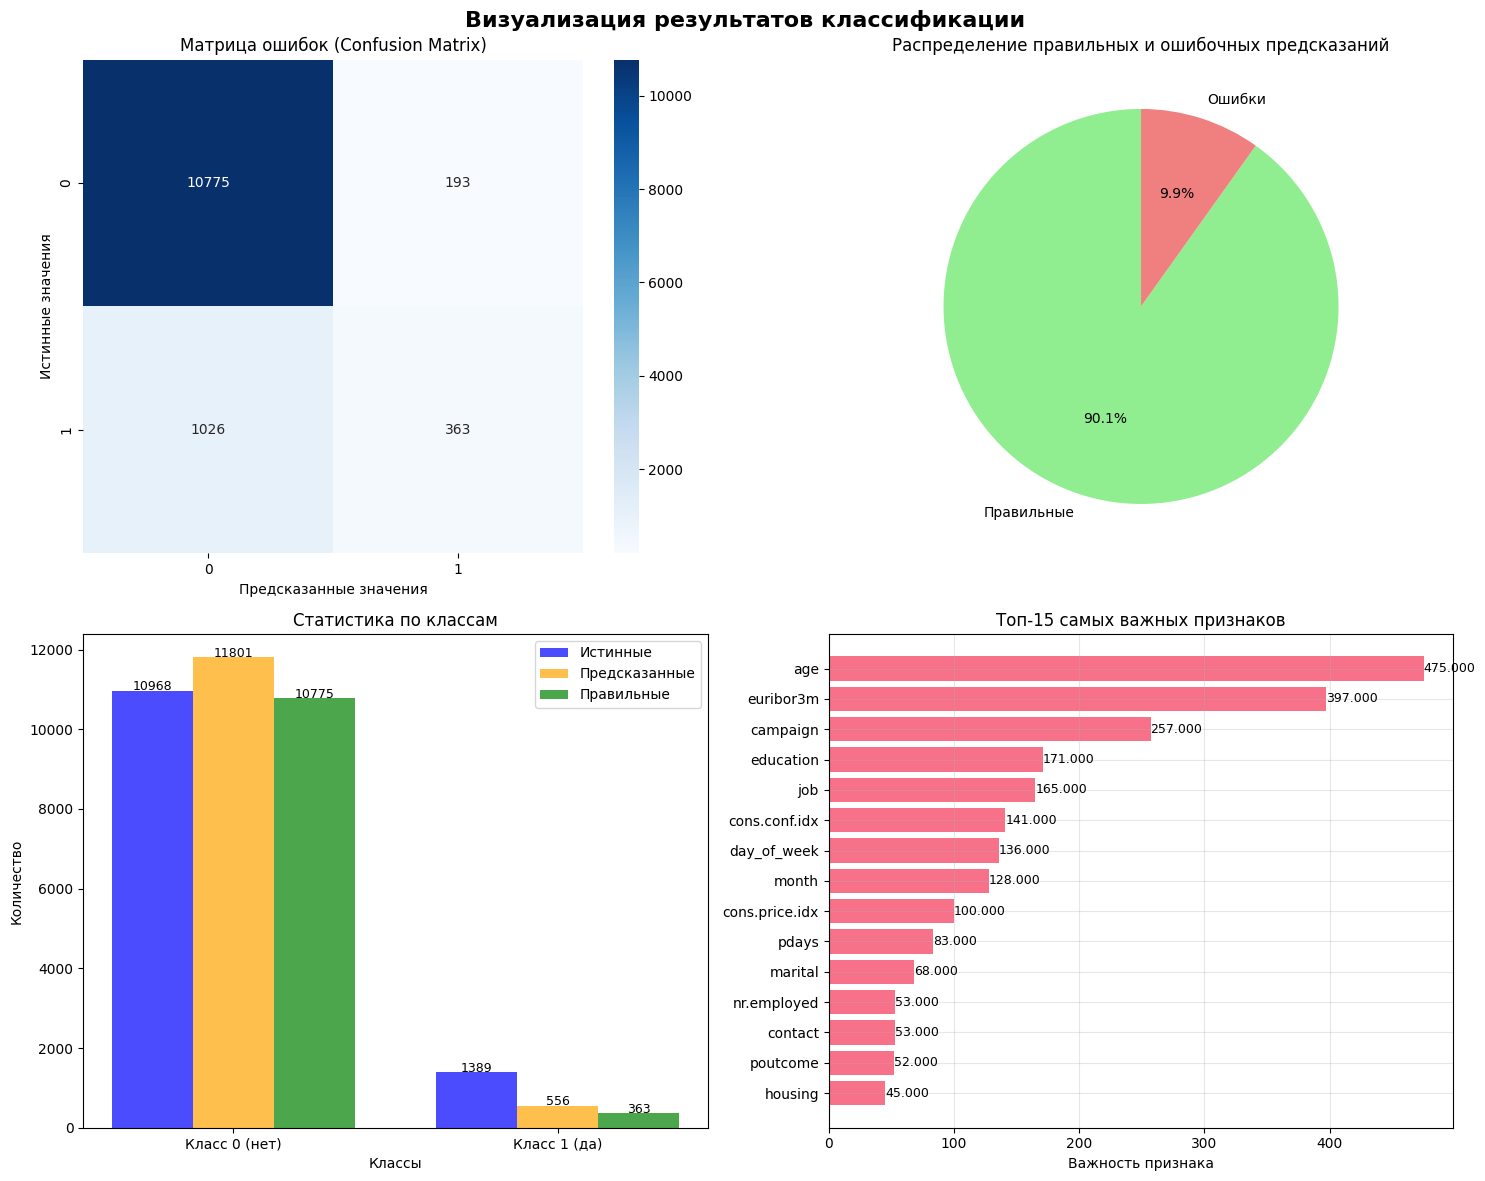


Точность модели: 0.9014
Количество правильных предсказаний: 11138/12357
Количество ошибок: 1219/12357

ОТЧЕТ КЛАССИФИКАЦИИ (LIGHTGBM)
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10968
           1       0.65      0.26      0.37      1389

    accuracy                           0.90     12357
   macro avg       0.78      0.62      0.66     12357
weighted avg       0.88      0.90      0.88     12357


СВОДНАЯ ТАБЛИЦА КОНФИГУРАЦИЙ LIGHTGBM
 Конфиг  n_estimators  learning_rate  max_depth  num_leaves  subsample Точность F1-Score
      1            50           0.10          3          31        1.0   0.9010   0.8776
      2           100           0.10          3          31        1.0   0.9001   0.8789
      3           100           0.05          3          31        1.0   0.9001   0.8762
      4           100           0.10          5          63        1.0   0.9014   0.8820
      5           150           0.10          3       

In [7]:
# @title Light Gradient Boosting Machine

import os
import pandas as pd
import sqlite3
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
import result_visualization


def load_data(db_file='bank_marketing.db'):
    """Загрузка данных из БД."""
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query('SELECT * FROM bank_marketing', conn)
        conn.close()

        X = df.drop('y', axis=1)
        y = df['y']

        return X, y
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None


def test_lightgbm_configurations(X_train, X_test, y_train, y_test):
    """Тестирование разных конфигураций LightGBM."""
    configurations = [
        {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3,
         'num_leaves': 31},
        {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3,
         'num_leaves': 31},
        {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3,
         'num_leaves': 31},
        {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5,
         'num_leaves': 63},
        {'n_estimators': 150, 'learning_rate': 0.1, 'max_depth': 3,
         'num_leaves': 31},
        {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 7,
         'num_leaves': 127},
        {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3,
         'num_leaves': 15},
        {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3,
         'num_leaves': 63, 'subsample': 0.8},
    ]

    results = []

    print("ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ LIGHTGBM")
    print("=" * 50)

    for i, config in enumerate(configurations, 1):
        print(f"\nКонфигурация {i}:")
        print(f"  n_estimators: {config['n_estimators']}")
        print(f"  learning_rate: {config['learning_rate']}")
        print(f"  max_depth: {config['max_depth']}")
        print(f"  num_leaves: {config['num_leaves']}")
        if 'subsample' in config:
            print(f"  subsample: {config['subsample']}")

        # Создаем модель LightGBM
        lgb_model = lgb.LGBMClassifier(
            n_estimators=config['n_estimators'],
            learning_rate=config['learning_rate'],
            max_depth=config['max_depth'],
            num_leaves=config['num_leaves'],
            subsample=config.get('subsample', 1.0),
            random_state=42,
            verbose=-1  # Отключаем вывод обучения
        )

        # Обучаем модель
        lgb_model.fit(X_train, y_train)

        # Предсказания
        y_pred = lgb_model.predict(X_test)
        y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

        # Метрики
        accuracy = accuracy_score(y_test, y_pred)
        f1 = result_visualization.safe_metrics_score(
            y_test, y_pred, f1_score, average='weighted'
        )

        results.append({
            'config': config,
            'accuracy': accuracy,
            'f1_score': f1,
            'model': lgb_model,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        })

        print(f"  Точность: {accuracy:.4f}")
        print(f"  F1-score: {f1:.4f}")

    return results


def analyze_lightgbm_model(model, feature_names):
    """Анализ LightGBM модели."""
    print(f"\nАнализ LightGBM модели:")

    # Информация о модели
    n_trees = model.n_estimators
    n_leaves = model.get_params()['num_leaves']
    best_iteration = model.best_iteration_ if hasattr(model, 'best_iteration_') else n_trees

    print(f"  Количество деревьев: {n_trees}")
    print(f"  Лучшая итерация: {best_iteration}")
    print(f"  Максимальное количество листьев: {n_leaves}")

    # Важность признаков
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        feature_imp_df = pd.DataFrame({
            'Признак': feature_names,
            'Важность': feature_importance
        }).sort_values('Важность', ascending=False).head(10)

        print(f"\nТоп-10 самых важных признаков:")
        for _, row in feature_imp_df.iterrows():
            print(f"  {row['Признак']}: {row['Важность']:.4f}")

        return feature_imp_df
    else:
        print("  Модель не поддерживает атрибут feature_importances_")
        return None


def compare_with_gradient_boosting(X_train, X_test, y_train, y_test):
    """Сравнение с классическим Gradient Boosting."""
    from sklearn.ensemble import GradientBoostingClassifier

    print("\n" + "=" * 50)
    print("СРАВНЕНИЕ С GRADIENT BOOSTING")
    print("=" * 50)

    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )

    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)

    accuracy_gb = accuracy_score(y_test, y_pred_gb)
    f1_gb = result_visualization.safe_metrics_score(
        y_test, y_pred_gb, f1_score, average='weighted'
    )

    print(f"\nGradient Boosting (scikit-learn):")
    print(f"  n_estimators: 100")
    print(f"  max_depth: 3")
    print(f"  learning_rate: 0.1")
    print(f"  Точность: {accuracy_gb:.4f}")
    print(f"  F1-score: {f1_gb:.4f}")

    return {
        'model': gb_model,
        'predictions': y_pred_gb,
        'accuracy': accuracy_gb,
        'f1_score': f1_gb
    }


def main():
    """Основная функция программы."""
    print("LIGHT GRADIENT BOOSTING MACHINE (LIGHTGBM)")
    print("=" * 60)

    try:
        # Загрузка данных
        print("\nЗагрузка данных...")
        X, y = load_data()

        if X is None or y is None:
            print("Не удалось загрузить данные")
            return

        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        print(f"Обучающая выборка: {X_train.shape}")
        print(f"Тестовая выборка: {X_test.shape}")
        print(f"Баланс классов в обучающей выборке:")
        print(f"  Класс 0 (нет): {np.sum(y_train == 0)} "
              f"({np.mean(y_train == 0):.2%})")
        print(f"  Класс 1 (да): {np.sum(y_train == 1)} "
              f"({np.mean(y_train == 1):.2%})")

        # Тестирование конфигураций LightGBM
        print("\n" + "=" * 60)
        print("ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ LIGHTGBM")
        print("=" * 60)

        lgb_results = test_lightgbm_configurations(X_train, X_test,
                                                 y_train, y_test)

        # Сравнение с Gradient Boosting
        gb_result = compare_with_gradient_boosting(X_train, X_test,
                                                 y_train, y_test)

        # Выбираем лучшую конфигурацию LightGBM
        best_lgb_result = max(lgb_results, key=lambda x: x['accuracy'])

        print(f"\n" + "=" * 60)
        print("ЛУЧШИЕ РЕЗУЛЬТАТЫ")
        print("=" * 60)

        # Лучший LightGBM
        lgb_config = best_lgb_result['config']
        print(f"\nЛучшая конфигурация LightGBM:")
        print(f"  n_estimators: {lgb_config['n_estimators']}")
        print(f"  learning_rate: {lgb_config['learning_rate']}")
        print(f"  max_depth: {lgb_config['max_depth']}")
        print(f"  num_leaves: {lgb_config['num_leaves']}")
        if 'subsample' in lgb_config:
            print(f"  subsample: {lgb_config['subsample']}")
        print(f"  Точность: {best_lgb_result['accuracy']:.4f}")

        # Анализ модели
        feature_imp_df = analyze_lightgbm_model(best_lgb_result['model'],
                                              X.columns.tolist())

        # Сравнительный анализ
        print(f"\n" + "=" * 50)
        print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ")
        print("=" * 50)

        lgb_accuracy = best_lgb_result['accuracy']
        gb_accuracy = gb_result['accuracy']

        print(f"\nСравнение производительности:")
        print(f"  LightGBM: {lgb_accuracy:.4f}")
        print(f"  Gradient Boosting: {gb_accuracy:.4f}")

        if lgb_accuracy > gb_accuracy:
            difference = lgb_accuracy - gb_accuracy
            print(f"  LightGBM лучше на {difference:.4f} "
                  f"({difference/gb_accuracy:.2%})")
        elif gb_accuracy > lgb_accuracy:
            difference = gb_accuracy - lgb_accuracy
            print(f"  Gradient Boosting лучше на {difference:.4f} "
                  f"({difference/lgb_accuracy:.2%})")
        else:
            print("  Модели показывают одинаковую точность")

        # Визуализация результатов LightGBM
        print("\n" + "=" * 60)
        print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ LIGHTGBM")
        print("=" * 60)

        print(f"\nВизуализация для лучшей конфигурации LightGBM:")
        result_visualization.plot_predictions(
            y_test,
            best_lgb_result['predictions'],
            model=best_lgb_result['model'],
            feature_names=X.columns.tolist()
        )

        # Детальный отчет для LightGBM
        print("\n" + "=" * 40)
        print("ОТЧЕТ КЛАССИФИКАЦИИ (LIGHTGBM)")
        print("=" * 40)
        report_lgb = result_visualization.safe_classification_report(
            y_test, best_lgb_result['predictions']
        )
        print(report_lgb)

        # Сводная таблица всех конфигураций LightGBM
        print("\n" + "=" * 80)
        print("СВОДНАЯ ТАБЛИЦА КОНФИГУРАЦИЙ LIGHTGBM")
        print("=" * 80)

        summary_data = []
        for i, result in enumerate(lgb_results, 1):
            config = result['config']

            summary_data.append({
                'Конфиг': i,
                'n_estimators': config['n_estimators'],
                'learning_rate': config['learning_rate'],
                'max_depth': config['max_depth'],
                'num_leaves': config['num_leaves'],
                'subsample': config.get('subsample', 1.0),
                'Точность': f"{result['accuracy']:.4f}",
                'F1-Score': f"{result['f1_score']:.4f}"
            })

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

        # Объяснение метода LightGBM
        print("\n" + "=" * 40)
        print("О МЕТОДЕ LIGHTGBM")
        print("=" * 40)
        print("LightGBM (Light Gradient Boosting Machine) - это:")
        print("- Высокоэффективная реализация градиентного бустинга")
        print("- Использует GOSS (Gradient-based One-Side Sampling)")
        print("- Использует EFB (Exclusive Feature Bundling)")
        print("- Особенности:")
        print("  • Более высокая скорость обучения")
        print("  • Меньшее потребление памяти")
        print("  • Поддержка больших объемов данных")
        print("  • Встроенная работа с категориальными признаками")
        print("- Ключевые параметры:")
        print("  • num_leaves: количество листьев в дереве")
        print("  • max_depth: ограничение глубины деревьев")
        print("  • learning_rate: скорость обучения")
        print("  • n_estimators: количество деревьев")

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")


if __name__ == "__main__":
    main()

ADABOOST С РАЗНЫМИ БАЗОВЫМИ КЛАССИФИКАТОРАМИ

Загрузка данных...
Обучающая выборка: (28831, 19)
Тестовая выборка: (12357, 19)
Баланс классов в обучающей выборке:
  Класс 0 (нет): 25580 (88.72%)
  Класс 1 (да): 3251 (11.28%)

ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ
ТЕСТИРОВАНИЕ ADABOOST С РАЗНЫМИ БАЗОВЫМИ КЛАССИФИКАТОРАМИ

Конфигурация 1: DecisionTree (max_depth=1)
  Точность: 0.8995
  F1-score: 0.8732
  Статус: Успешно

Конфигурация 2: DecisionTree (max_depth=2)
  Точность: 0.8990
  F1-score: 0.8720
  Статус: Успешно

Конфигурация 3: DecisionTree (max_depth=5)
  Точность: 0.8997
  F1-score: 0.8803
  Статус: Успешно

Конфигурация 4: LogisticRegression (C=1.0)
  Точность: 0.8968
  F1-score: 0.8774
  Статус: Успешно

Конфигурация 5: LogisticRegression (C=0.1)
  Точность: 0.8973
  F1-score: 0.8763
  Статус: Успешно

Конфигурация 6: GaussianNB
  Точность: 0.8827
  F1-score: 0.8652
  Статус: Успешно

Конфигурация 7: KNeighbors (n=5)
  Статус: Ошибка - KNeighborsClassifier doesn't support sample_weight....

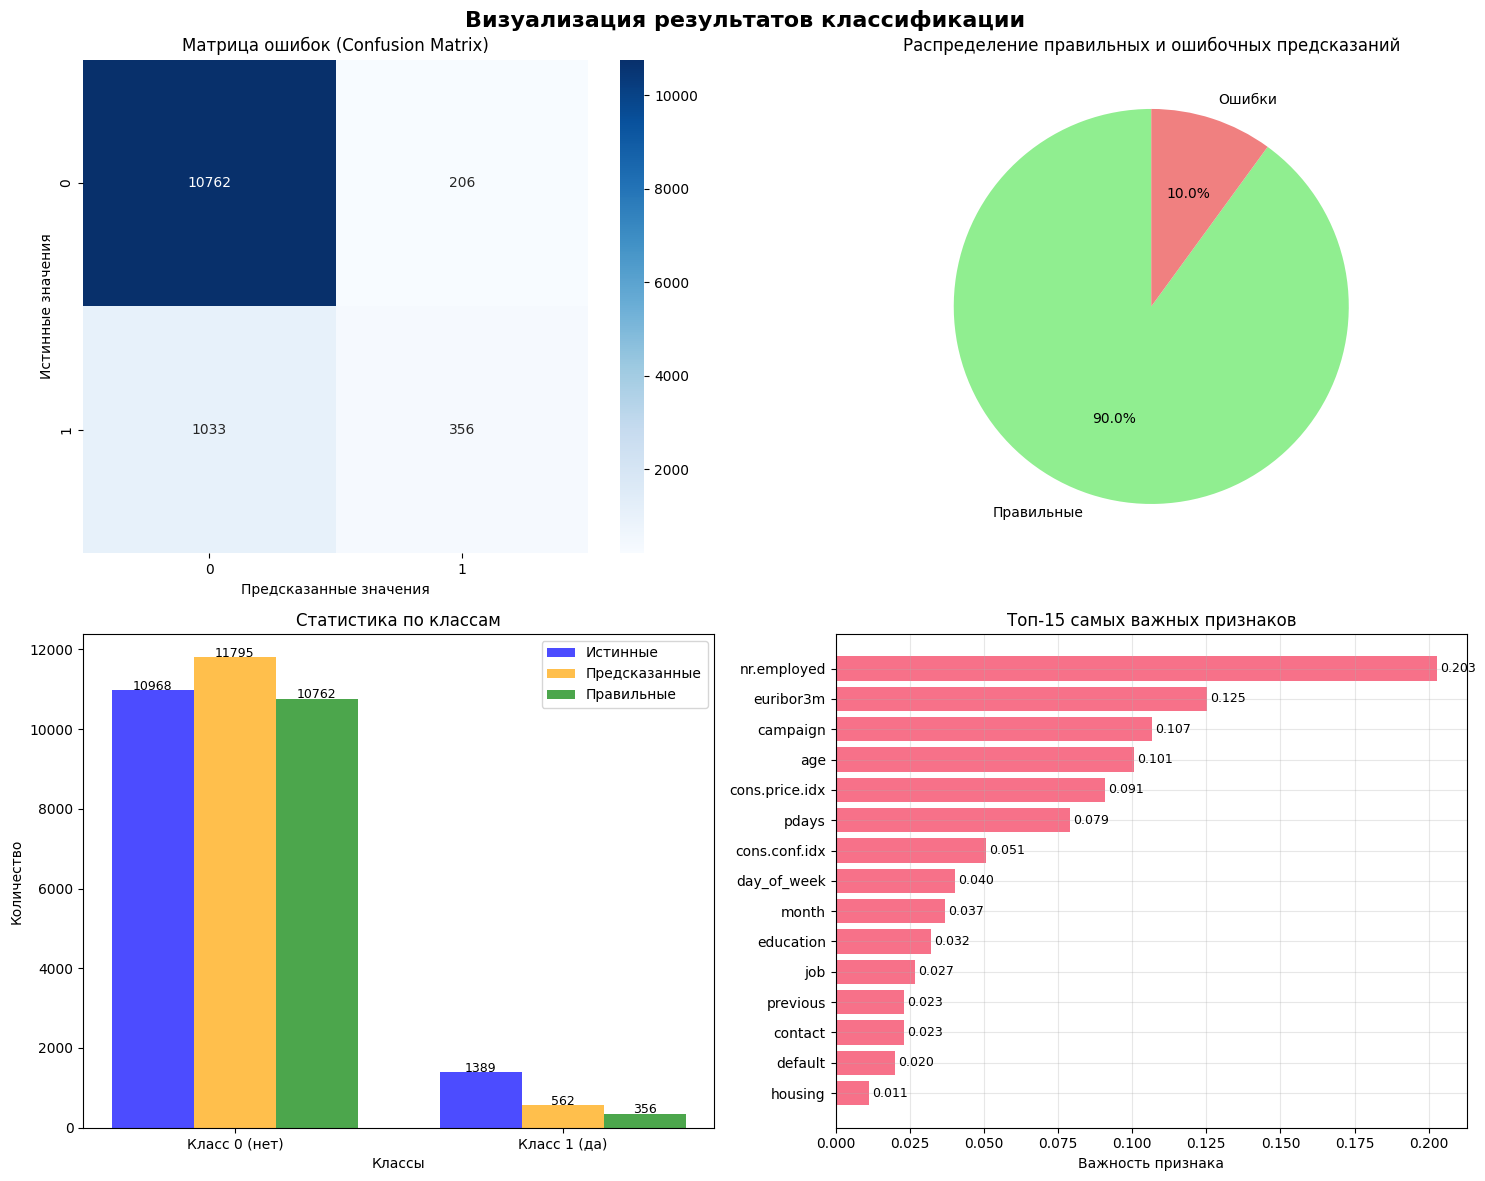


Точность модели: 0.8997
Количество правильных предсказаний: 11118/12357
Количество ошибок: 1239/12357

ОТЧЕТ КЛАССИФИКАЦИИ
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10968
           1       0.63      0.26      0.36      1389

    accuracy                           0.90     12357
   macro avg       0.77      0.62      0.66     12357
weighted avg       0.88      0.90      0.88     12357


СВОДНАЯ ТАБЛИЦА ВСЕХ КОНФИГУРАЦИЙ
 №      Базовый классификатор Точность F1-Score
 1 DecisionTree (max_depth=1)   0.8995   0.8732
 2 DecisionTree (max_depth=2)   0.8990   0.8720
 3 DecisionTree (max_depth=5)   0.8997   0.8803
 4 LogisticRegression (C=1.0)   0.8968   0.8774
 5 LogisticRegression (C=0.1)   0.8973   0.8763
 6                 GaussianNB   0.8827   0.8652
 7     DecisionTree (default)   0.8995   0.8732

О БАЗОВЫХ КЛАССИФИКАТОРАХ ДЛЯ ADABOOST

Decision Trees (наиболее популярные):
- 'Слабые' деревья (малой глубины) хорошо работают 

In [1]:
# @title AdaBoost

import os
import pandas as pd
import sqlite3
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import result_visualization


def load_data(db_file='bank_marketing.db'):
    """Загрузка данных из БД."""
    try:
        conn = sqlite3.connect(db_file)
        df = pd.read_sql_query('SELECT * FROM bank_marketing', conn)
        conn.close()

        X = df.drop('y', axis=1)
        y = df['y']

        return X, y
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return None, None


def test_adaboost_with_different_estimators(X_train, X_test, y_train, y_test):
    """Тестирование AdaBoost с разными базовыми классификаторами."""

    # Разные базовые классификаторы для AdaBoost
    configurations = [
        # Decision Trees (наиболее популярные для AdaBoost)
        {'name': 'DecisionTree (max_depth=1)',
         'estimator': DecisionTreeClassifier(max_depth=1, random_state=42)},
        {'name': 'DecisionTree (max_depth=2)',
         'estimator': DecisionTreeClassifier(max_depth=2, random_state=42)},
        {'name': 'DecisionTree (max_depth=5)',
         'estimator': DecisionTreeClassifier(max_depth=5, random_state=42)},

        # Линейные модели
        {'name': 'LogisticRegression (C=1.0)',
         'estimator': LogisticRegression(C=1.0, random_state=42, max_iter=1000)},
        {'name': 'LogisticRegression (C=0.1)',
         'estimator': LogisticRegression(C=0.1, random_state=42, max_iter=1000)},

        # Наивный Байес
        {'name': 'GaussianNB',
         'estimator': GaussianNB()},

        # K-ближайших соседей
        {'name': 'KNeighbors (n=5)',
         'estimator': KNeighborsClassifier(n_neighbors=5)},
        {'name': 'KNeighbors (n=10)',
         'estimator': KNeighborsClassifier(n_neighbors=10)},

        # Decision Tree по умолчанию (для сравнения)
        {'name': 'DecisionTree (default)',
         'estimator': None},
    ]

    results = []

    print("ТЕСТИРОВАНИЕ ADABOOST С РАЗНЫМИ БАЗОВЫМИ КЛАССИФИКАТОРАМИ")
    print("=" * 70)

    for i, config in enumerate(configurations, 1):
        print(f"\nКонфигурация {i}: {config['name']}")

        # Создаем модель AdaBoost
        ada_model = AdaBoostClassifier(
            estimator=config['estimator'],
            n_estimators=100,
            learning_rate=1.0,
            random_state=42
        )

        try:
            # Обучаем модель
            ada_model.fit(X_train, y_train)

            # Предсказания
            y_pred = ada_model.predict(X_test)

            # Метрики
            accuracy = accuracy_score(y_test, y_pred)
            f1 = result_visualization.safe_metrics_score(
                y_test, y_pred, f1_score, average='weighted'
            )

            results.append({
                'name': config['name'],
                'estimator': config['estimator'],
                'accuracy': accuracy,
                'f1_score': f1,
                'model': ada_model,
                'predictions': y_pred
            })

            print(f"  Точность: {accuracy:.4f}")
            print(f"  F1-score: {f1:.4f}")
            print(f"  Статус: Успешно")

        except Exception as e:
            print(f"  Статус: Ошибка - {str(e)[:100]}...")
            continue

    return results


def analyze_estimator_performance(results):
    """Анализ производительности разных базовых классификаторов."""
    print("\n" + "=" * 70)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ БАЗОВЫХ КЛАССИФИКАТОРОВ")
    print("=" * 70)

    # Группируем по типам классификаторов
    classifier_types = {}
    for result in results:
        estimator_name = result['name']
        if 'DecisionTree' in estimator_name:
            classifier_type = 'Decision Trees'
        elif 'LogisticRegression' in estimator_name:
            classifier_type = 'Linear Models'
        elif 'GaussianNB' in estimator_name:
            classifier_type = 'Naive Bayes'
        elif 'KNeighbors' in estimator_name:
            classifier_type = 'K-Neighbors'
        else:
            classifier_type = 'Other'

        if classifier_type not in classifier_types:
            classifier_types[classifier_type] = []
        classifier_types[classifier_type].append(result)

    # Анализ по типам
    print("\nПроизводительность по типам классификаторов:")
    print("-" * 50)

    for classifier_type, type_results in classifier_types.items():
        best_in_type = max(type_results, key=lambda x: x['accuracy'])
        avg_accuracy = np.mean([r['accuracy'] for r in type_results])

        print(f"\n{classifier_type}:")
        print(f"  Лучшая точность: {best_in_type['accuracy']:.4f} "
              f"({best_in_type['name']})")
        print(f"  Средняя точность: {avg_accuracy:.4f}")
        print(f"  Количество конфигураций: {len(type_results)}")


def main():
    """Основная функция программы."""
    print("ADABOOST С РАЗНЫМИ БАЗОВЫМИ КЛАССИФИКАТОРАМИ")
    print("=" * 60)

    try:
        # Загрузка данных
        print("\nЗагрузка данных...")
        X, y = load_data()

        if X is None or y is None:
            print("Не удалось загрузить данные")
            return

        # Разделение данных
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        print(f"Обучающая выборка: {X_train.shape}")
        print(f"Тестовая выборка: {X_test.shape}")
        print(f"Баланс классов в обучающей выборке:")
        print(f"  Класс 0 (нет): {np.sum(y_train == 0)} "
              f"({np.mean(y_train == 0):.2%})")
        print(f"  Класс 1 (да): {np.sum(y_train == 1)} "
              f"({np.mean(y_train == 1):.2%})")

        # Тестирование AdaBoost с разными классификаторами
        print("\n" + "=" * 70)
        print("ТЕСТИРОВАНИЕ КОНФИГУРАЦИЙ")
        print("=" * 70)

        results = test_adaboost_with_different_estimators(X_train, X_test,
                                                        y_train, y_test)

        if not results:
            print("Ни одна конфигурация не завершилась успешно")
            return

        # Анализ производительности
        analyze_estimator_performance(results)

        # Выбираем лучшую конфигурацию
        best_result = max(results, key=lambda x: x['accuracy'])

        print(f"\n" + "=" * 60)
        print("ЛУЧШАЯ КОНФИГУРАЦИЯ")
        print("=" * 60)

        print(f"\nЛучший базовый классификатор: {best_result['name']}")
        print(f"Точность: {best_result['accuracy']:.4f}")
        print(f"F1-Score: {best_result['f1_score']:.4f}")

        # Визуализация результатов лучшей конфигурации
        print("\n" + "=" * 60)
        print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
        print("=" * 60)

        print(f"\nВизуализация для лучшей конфигурации:")
        result_visualization.plot_predictions(
            y_test,
            best_result['predictions'],
            model=best_result['model'],
            feature_names=X.columns.tolist()
        )

        # Детальный отчет
        print("\n" + "=" * 40)
        print("ОТЧЕТ КЛАССИФИКАЦИИ")
        print("=" * 40)
        report = result_visualization.safe_classification_report(
            y_test, best_result['predictions']
        )
        print(report)

        # Сводная таблица всех конфигураций
        print("\n" + "=" * 80)
        print("СВОДНАЯ ТАБЛИЦА ВСЕХ КОНФИГУРАЦИЙ")
        print("=" * 80)

        summary_data = []
        for i, result in enumerate(results, 1):
            summary_data.append({
                '№': i,
                'Базовый классификатор': result['name'],
                'Точность': f"{result['accuracy']:.4f}",
                'F1-Score': f"{result['f1_score']:.4f}"
            })

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

        # Объяснение различных базовых классификаторов
        print("\n" + "=" * 50)
        print("О БАЗОВЫХ КЛАССИФИКАТОРАХ ДЛЯ ADABOOST")
        print("=" * 50)

        print("\nDecision Trees (наиболее популярные):")
        print("- 'Слабые' деревья (малой глубины) хорошо работают в AdaBoost")
        print("- Быстрые в обучении и предсказании")
        print("- Хорошо обрабатывают различные типы данных")

        print("\nLinear Models (Logistic Regression):")
        print("- Линейные границы принятия решений")
        print("- Хорошо работают на линейно разделимых данных")
        print("- Менее гибкие, но более интерпретируемые")

        print("\nNaive Bayes:")
        print("- Быстрый и простой алгоритм")
        print("- Предположение о независимости признаков")
        print("- Хорош для текстовых данных")

        print("\nK-Nearest Neighbors:")
        print("- Непараметрический метод")
        print("- Чувствителен к масштабированию данных")
        print("- Может быть медленным при предсказании")

        print("\nРекомендации:")
        print("- Decision Trees обычно работают лучше всего в AdaBoost")
        print("- Начинайте с деревьев глубиной 1-3")
        print("- Экспериментируйте с разными типами для ваших данных")

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")


if __name__ == "__main__":
    main()